<a href="https://colab.research.google.com/github/Ivelina0/Earth_Observation-Codedddd/blob/main/K_means_Clustering_SAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [ ]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
# from aenum import MultiValueEnum

# Basics of Python data handling and visualization
import numpy as np
np.random.seed(42)
!pip install geopandas
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm.auto import tqdm
import json
import fiona

# Machine learning
import lightgbm as lgb
import joblib
from sklearn import metrics
from sklearn import preprocessing
from scipy import ndimage, misc
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Imports from eo-learn and sentinelhub-py
!pip install eo-learn
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io import SentinelHubInputTask, VectorImportTask, ExportToTiff
from eolearn.mask import AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, NormalizedDifferenceIndexTask
from sentinelhub import UtmZoneSplitter, BBox, CRS, DataCollection
import matplotlib.pyplot as plt
%matplotlib inline

     |████████████████████████████████| 994 kB 15.3 MB/s 
     |████████████████████████████████| 15.4 MB 34 kB/s 
     |████████████████████████████████| 6.6 MB 29.4 MB/s 
     |████████████████████████████████| 47 kB 3.5 MB/s 
     |████████████████████████████████| 10.5 MB 110 kB/s 
     |████████████████████████████████| 131 kB 63.3 MB/s 
     |████████████████████████████████| 131 kB 59.1 MB/s 
     |████████████████████████████████| 196 kB 56.6 MB/s 
     |████████████████████████████████| 43.3 MB 13 kB/s 
     |████████████████████████████████| 18.3 MB 80 kB/s 
     |████████████████████████████████| 994 kB 31.6 MB/s 
     |████████████████████████████████| 7.8 MB 59.4 MB/s 
     |████████████████████████████████| 123 kB 53.0 MB/s 
     |████████████████████████████████| 79 kB 5.9 MB/s 
     |████████████████████████████████| 127 kB 32.8 MB/s 
     |████████████████████████████████| 47 kB 4.1 MB/s 
     |████████████████████████████████| 44 kB 1.8 MB/s 
     |███████████████████

/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Tim's drive dir

In [ ]:
cd /content/drive/My Drive/EarthI/Jsonfiles/eopatches/

[Errno 2] No such file or directory: '/content/drive/My Drive/EarthI/Jsonfiles/eopatches/'
/content


Ive's drive dir

In [ ]:
cd /drive/MyDrive/ColabNotebooks/EarthI/Jsonfiles/eopatches

[Errno 2] No such file or directory: '/drive/MyDrive/ColabNotebooks/EarthI/Jsonfiles/eopatches'
/content


In [ ]:
ls drive/MyDrive/ColabNotebooks/

ls: cannot access 'drive/MyDrive/ColabNotebooks/': No such file or directory


___ 
**Methodology** after downloading image time series
___ 

1.   Set any values of 0 in the image to some arbitrary small number, e.g. 0.000001.
2.   Make every pixel in all of your images one row in a dataset.
3.   Calculate the IQR of the pixel data and set any outleirs to the upper whisker of the 'box plot'. (To filter out outliers.)  
4.   Take the log of all the pixel valiues in the row dataset.
5.   Train a kmeans model with n_clusters set to 2 - on/off pixels.
6.   Extract and reshape the k-means labels into the initial image time series shape. 

----

**AOI Methodology** after clustering the time series
___
1.   Sum the image time series created by the k-means labels to create one imagewith pixels values ranging from 0 to the n-th time stamp. e.g. there are 101 image time series so the summed labels would create pixle values from 0-101.

> The 'summed' labels create an image where if

*   Pixel value = 0, then there has been no change in that pixel for the whole time series, i.e. the pixel has been 'off' the whole time.
*   Pixel value > 0 and PV < n (last time step), then there has been some change in that pixel for the whole time series.
*   Pixel value = n, then there has been no change in that pixel value for the whole time series too, i.e. the pixel has been 'on' the whole time.

> **AOI**

2.   Create *top* and *bottom* percentage filters by taking an arbitrary %*n, e.g. bottom % is 0.25n. This is arbitrary and gets rid of any pixels that are mostly 'off' or 'on' but have changed a little bit throughout the time period. 
3.   Filter out the 'summed' pixel values (summed image) again by setting anything above the top % values to 0 and anything below the bottom % values to 0 too. This creates the filter for the pixels that change a little bit.
4.   Flatten the image into an array. 
5.   AOI = taken the index of all the pixel values > 0 from the flatten array.
6.   AOI as a % of image = lenth of aoi array / length of flatten image array. Things to think about are: how big do we want this AOI to be as a % of the whole image? How big is good enough to get accurate results without taking on too much noisy pixels?

____
**The pos/neg change time series**
____

1.   Take the difference between image n-1 and image n, using the time series created by the k-means labels above. This will create an n-1 time series.
2.   Flatten the n-1 differenced time series for each differenced image and filter out the AOI by using the AOI index made earlier. 
3.   This created another time series of shape: len(AOI) x (n-1), with pixel values from {-1,0,1}. 

> Classifying pixels in differenced AOI time series  

* Create a for loop that goes through the AOI pixels at each time step and counts the number of positive (==+1), negative (==-1) and no change (==0) pixels. That creates the inital time series.


# Download images from Sentinel Hub

In [ ]:
## Connect to Sentinel Hub

In [ ]:
! sentinelhub.config --sh_client_secret "uG+Qro_@!wmGj^YhnznaE6|2@UBzuD:F</OPi7m<" --instance_id "a7b69c97-7480-44db-ba03-9b7a9f4fb61d" --sh_client_id "e6ead4c7-0bad-4218-aa81-16379a0c4fd3"

In [ ]:
## Function to download SAR images from Sentinel Hub
def get_sar_images(directory,time_interval):    
    add_data = SentinelHubInputTask(
        bands_feature=(FeatureType.DATA, 'BANDS'),
        resolution=10,
        maxcc=0.8,
        time_difference=datetime.timedelta(minutes=120),
        data_collection=DataCollection.SENTINEL1_IW,#_ASC,
        max_threads=5
    )
    save = SaveTask('eopatches', overwrite_permission=OverwritePermission.OVERWRITE_PATCH)
    workflow = LinearWorkflow(add_data, save)
    execution_args = []
    for smelter in os.listdir(directory):
        #smelter_name = smelter.split('.')[0]
        smelter_name = smelter
        print(smelter_name)
        # file = open(filename)
        smelter = gpd.read_file(open(smelter_name))
        bounds = [[smelter.bounds.minx.values[0],smelter.bounds.miny.values[0]],
                      [smelter.bounds.maxx.values[0],smelter.bounds.maxy.values[0]]]
        print(bounds)
        bbox = BBox(bounds,crs=smelter.crs)
        execution_args.append({
            add_data: {'bbox': bbox, 'time_interval': time_interval},
            save: {'eopatch_folder': smelter_name}
        })
    #Execture the workflow
    executor = EOExecutor(workflow, execution_args, save_logs=True)
    executor.run(workers=7, multiprocess=True)
    executor.make_report()

In [ ]:
## Set times and get your directory 
time_interval = ['2013-01-01', '2021-06-15']
path = os.getcwd()
print(path)
## Download images onto your file path
get_sar_images(path, time_interval)

# Upload one smelter for analysis

In [ ]:
## Go to eopatch folder after downlaoding the images

In [ ]:
cd /content/drive/MyDrive/ColabNotebooks/EarthI/Jsonfiles/eopatches

/content/drive/MyDrive/ColabNotebooks/EarthI/Jsonfiles/eopatches


In [ ]:
## choose a smelter to upload onto the notebook
smelter_name = 'hayden.json'

# Load eopatch for one smelter
path = os.getcwd()
eopatch = EOPatch.load(os.path.join(path,smelter_name))

# eopatch array 
eopatch_arr = eopatch.data['BANDS']

# setting the 0s to 0.00001 values for log operator to work 
eopatch_arr[eopatch_arr == 0] = 0.0000001

# K-means only code

In [ ]:
# get array details
n = eopatch_arr.shape[0]
x = eopatch_arr.shape[1]
y = eopatch_arr.shape[2]
bands = eopatch_arr.shape[3]

# reshaping
eopatch_arr_res = eopatch_arr.reshape( n*x*y,bands)

# rescaling by log
eopatch_log = np.log(eopatch_arr_res)

# k-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(eopatch_log)

# getting the labels of the pixels 
eopatch_kmeans_labels = kmeans.labels_

# reshaping the labelled pixels back into its original time series form
eopatch_kmeans_ts = eopatch_kmeans_labels.reshape(n,x,y)

# the sum of all labels over the time series - creating a change map
sum_labels = np.sum(eopatch_kmeans_ts, axis=0)

# K-means with percentile filtering

In [ ]:
# get array details
n = eopatch_arr.shape[0]
x = eopatch_arr.shape[1]
y = eopatch_arr.shape[2]
bands = eopatch_arr.shape[3]

# reshaping
eopatch_arr_res = eopatch_arr.reshape(n*x*y,bands)

# getting the statistics for each band - VV and VH
qrt1_vv, median_vv, qrt3_vv = np.percentile(eopatch_arr_res[:,0],25) , np.percentile(eopatch_arr_res[:,0],50) , np.percentile(eopatch_arr_res[:,0],75) 
qrt1_vh, median_vh, qrt3_vh = np.percentile(eopatch_arr_res[:,1],25) , np.percentile(eopatch_arr_res[:,1],50) , np.percentile(eopatch_arr_res[:,1],75) 

# IQR 
iqr_vv = qrt3_vv - qrt1_vv
iqr_vh = qrt3_vh - qrt1_vh

### Calculating the Min & Max 
#vv
min_vv = qrt1_vv - (1.5*iqr_vv)
max_vv = qrt3_vv + (1.5*iqr_vv)
#vh
min_vh = qrt1_vh - (1.5*iqr_vh)
max_vh = qrt3_vh + (1.5*iqr_vh)

print(min_vv, qrt1_vv, median_vv, qrt3_vv, max_vv)
print(min_vh, qrt1_vh, median_vh, qrt3_vh, max_vh)

# ignore negative min values 
# setting the upper values to max of the maximum box plot values for vv and vh
eopatch_arr_res[:,0][eopatch_arr_res[:,0] > max_vv] = max_vv
eopatch_arr_res[:,1][eopatch_arr_res[:,1] > max_vh] = max_vh

# checking it works
# np.max(eopatch_arr_res[:,0]), np.max(eopatch_arr_res[:,1])

# rescaling by log
eopatch_log_filt = np.log(eopatch_arr_res)

# k-means clustering
kmeans_filt = KMeans(n_clusters=2, random_state=0).fit(eopatch_log_filt)

# getting the labels of the pixels 
eopatch_kmeans_labels_filt = kmeans_filt.labels_

# reshaping the labelled pixels back into its original time series form
eopatch_kmeans_ts_filt = eopatch_kmeans_labels_filt.reshape(n,x,y)

# the sum of all labels over the time series - creating a change map
sum_labels_filt = np.sum(eopatch_kmeans_ts_filt, axis=0)

-0.23394998908042908 0.0812000036239624 0.14869999885559082 0.2912999987602234 0.6064499914646149
-0.044549998827278614 0.015300000086426735 0.029100000858306885 0.0551999993622303 0.11504999827593565


# K-means only vs K-means with percentile fitlering

The bottom two images are median filtered too. 

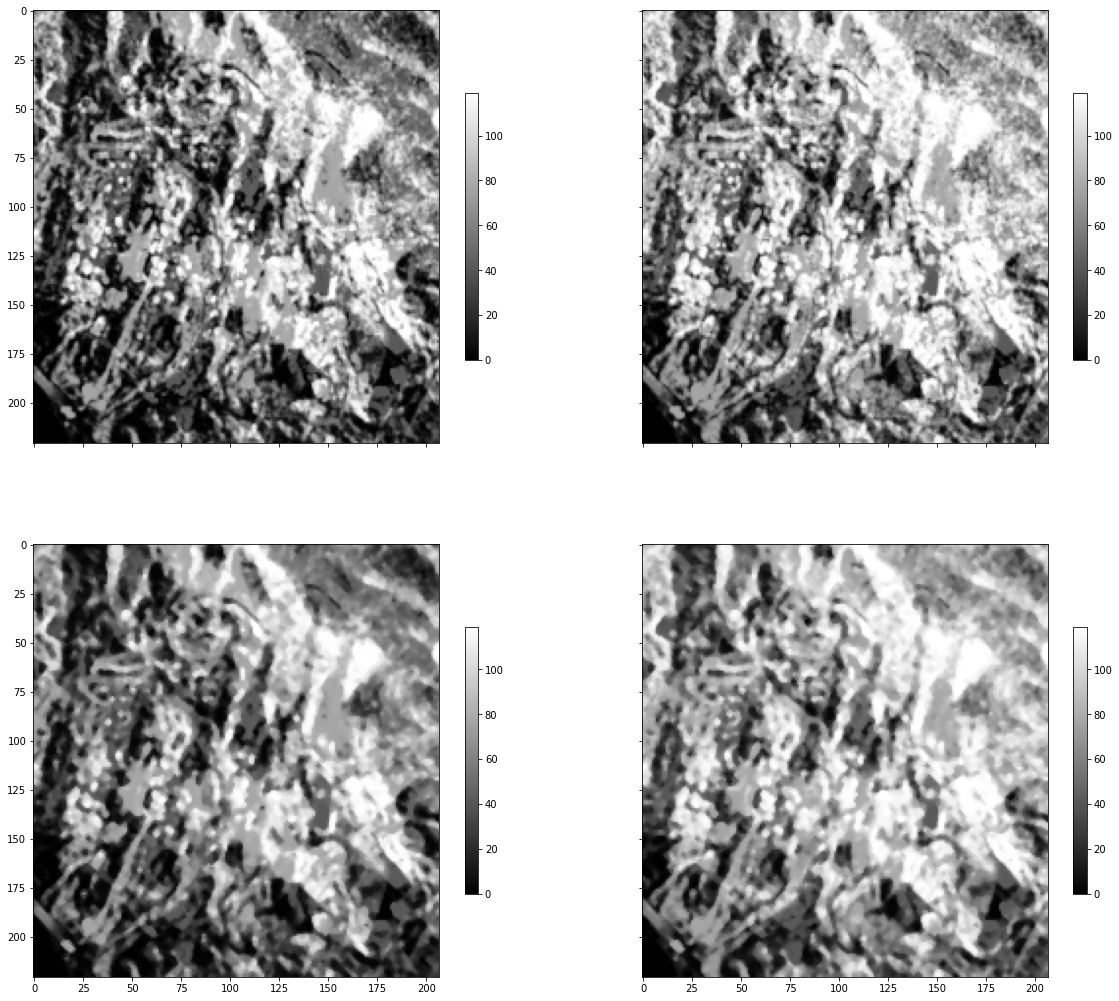

In [ ]:
# Med filtered
sum_labels_medfilt = ndimage.median_filter(sum_labels, size=3)
sum_labels_filt_medfilt = ndimage.median_filter(sum_labels_filt, size=3)

# the sum of all labels over the time series - creating a change map
fig, ax = plt.subplots(2,2,figsize=(20,18),sharex=True,sharey=True)

im1 = ax[0,0].imshow(sum_labels, cmap='gray')
plt.colorbar(im1,  ax=ax[0,0], shrink=0.6)

im2 = ax[1,0].imshow(sum_labels_medfilt, cmap='gray')
plt.colorbar(im2,  ax=ax[1,0], shrink=0.6)

im3 = ax[0,1].imshow(sum_labels_filt, cmap='gray')
plt.colorbar(im3,  ax=ax[0,1], shrink=0.6)

im4 = ax[1,1].imshow(sum_labels_filt_medfilt, cmap='gray')
plt.colorbar(im4,  ax=ax[1,1], shrink=0.6);

# K-means with percentile filtering on specific years

In [ ]:
# load eopatch for one smelter
path = os.getcwd()
eopatch = EOPatch.load(os.path.join(path,smelter_name))

# eopatch array 
eopatch_arr = eopatch.data['BANDS']

# Clean up the eopatch datetimes & add to a list
times = []

for i in eopatch.timestamp:
  times.append(i.replace(tzinfo=None))

# Get the index & dates for eopatches occuring in specific year
yr = 2018
eo_time_ind =[]
eo_dates = []

for i, dates in enumerate(times):
  if dates.year == yr:
    eo_time_ind.append(i)
    eo_dates.append(dates)

eopatch_arr_yr = eopatch_arr[eo_time_ind]

# reshaping the array before plugging it to the K-means cluster
n = eopatch_arr_yr.shape[0]
x = eopatch_arr_yr.shape[1]
y = eopatch_arr_yr.shape[2]
bands = eopatch_arr_yr.shape[3]

eopatch_arr_yr_res = eopatch_arr_yr.reshape(n*x*y,bands)

# getting the statistics for each band - VV and VH
qrt1_vv, median_vv, qrt3_vv = np.percentile(eopatch_arr_yr_res[:,0],25) , np.percentile(eopatch_arr_yr_res[:,0],50) , np.percentile(eopatch_arr_yr_res[:,0],75) 
qrt1_vh, median_vh, qrt3_vh = np.percentile(eopatch_arr_yr_res[:,1],25) , np.percentile(eopatch_arr_yr_res[:,1],50) , np.percentile(eopatch_arr_yr_res[:,1],75) 

# IQR 
iqr_vv = qrt3_vv - qrt1_vv
iqr_vh = qrt3_vh - qrt1_vh

### Calculating the Min & Max 
#vv
min_vv = qrt1_vv - (1.5*iqr_vv)
max_vv = qrt3_vv + (1.5*iqr_vv)
#vh
min_vh = qrt1_vh - (1.5*iqr_vh)
max_vh = qrt3_vh + (1.5*iqr_vh)

# ignore negative min values 
# setting the upper values to max of the maximum box plot values for vv and vh
eopatch_arr_yr_res[:,0][eopatch_arr_yr_res[:,0] > max_vv] = max_vv
eopatch_arr_yr_res[:,1][eopatch_arr_yr_res[:,1] > max_vh] = max_vh

# setting the 0s to 0.00001 values for log operator to work 
eopatch_arr_yr_res[eopatch_arr_yr_res == 0] = 0.00001

# rescaling by log
eopatch_yr_res_log = np.log(eopatch_arr_yr_res)

# k-means clustering
kmeans_yr = KMeans(n_clusters=2, random_state=0).fit(eopatch_yr_res_log)

# getting the labels of the pixels 
kmeans_yr_labels = kmeans_yr.labels_

# reshaping the labelled pixels back into its original time series form
kmeans_yr_labels_ts = kmeans_yr_labels.reshape(n,x,y)

# the sum of all labels over the time series - creating a change map
sum_labels_yr = np.sum(kmeans_yr_labels_ts, axis=0)

-0.2302500121295452 0.08129999786615372 0.14640000462532043 0.289000004529953 0.6005500145256519
-0.04210000019520521 0.01549999974668026 0.02850000001490116 0.05389999970793724 0.11149999964982271


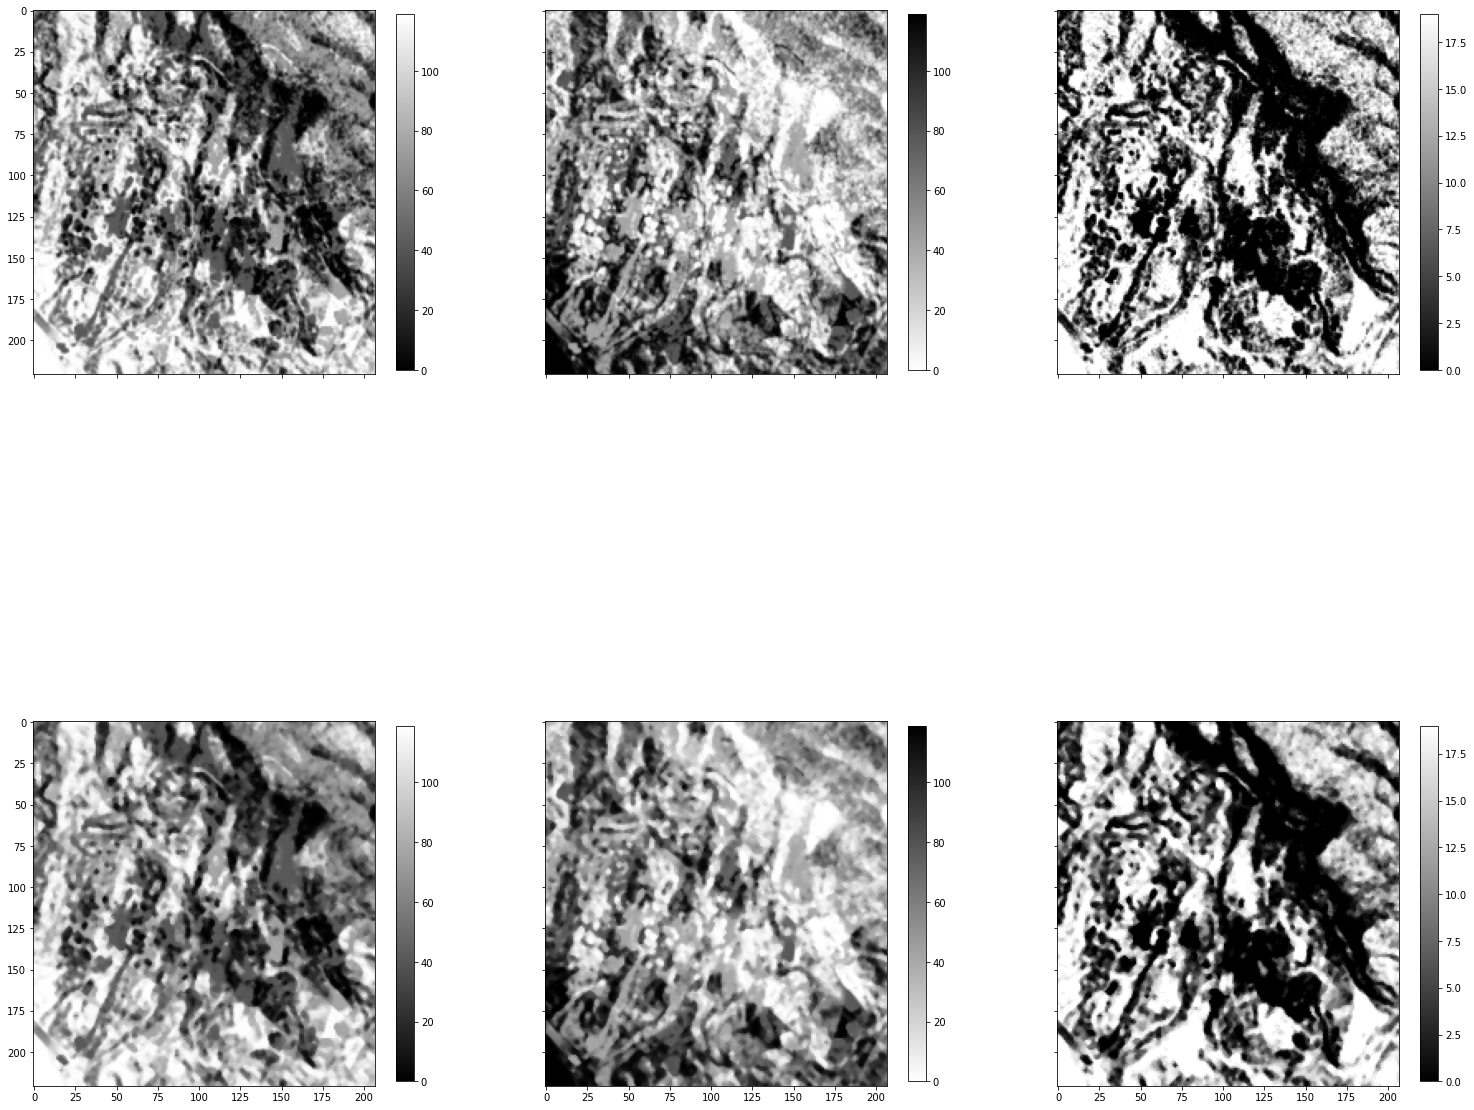

In [ ]:
# Med filtered
sum_labels_medfilt = ndimage.median_filter(sum_labels, size=3)
sum_labels_filt_medfilt = ndimage.median_filter(sum_labels_filt, size=3)
sum_labels_medfilt_yr = ndimage.median_filter(sum_labels_yr, size=3)

# the sum of all labels over the time series - creating a change map
fig, ax = plt.subplots(2,3,figsize=(26,24),sharex=True,sharey=True)

im1 = ax[0,0].imshow(sum_labels, cmap='gray')
plt.colorbar(im1,  ax=ax[0,0], shrink=0.6)

im2 = ax[1,0].imshow(sum_labels_medfilt, cmap='gray')
plt.colorbar(im2,  ax=ax[1,0], shrink=0.6)

im3 = ax[0,1].imshow(sum_labels_filt, cmap='gray_r')
plt.colorbar(im3,  ax=ax[0,1], shrink=0.6)

im4 = ax[1,1].imshow(sum_labels_filt_medfilt, cmap='gray_r')
plt.colorbar(im4,  ax=ax[1,1], shrink=0.6)

im5 = ax[0,2].imshow(sum_labels_yr, cmap='gray')
plt.colorbar(im5,  ax=ax[0,2], shrink=0.6)

im6 = ax[1,2].imshow(sum_labels_medfilt_yr, cmap='gray')
plt.colorbar(im6,  ax=ax[1,2], shrink=0.6);

In [ ]:
# load eopatch for one smelter
path = os.getcwd()
eopatch = EOPatch.load(os.path.join(path,smelter_name))

# eopatch array 
eopatch_arr = eopatch.data['BANDS']

# Clean up the eopatch datetimes & add to a list
times = []

for i in eopatch.timestamp:
  times.append(i.replace(tzinfo=None))

# Get the index & dates for eopatches occuring in specific year
yr = 2019
eo_time_ind =[]
eo_dates = []

for i, dates in enumerate(times):
  if dates.year == yr:
    eo_time_ind.append(i)
    eo_dates.append(dates)

eopatch_arr_yr = eopatch_arr[eo_time_ind]

# reshaping the array before plugging it to the K-means cluster
n = eopatch_arr_yr.shape[0]
x = eopatch_arr_yr.shape[1]
y = eopatch_arr_yr.shape[2]
bands = eopatch_arr_yr.shape[3]

eopatch_arr_yr_res = eopatch_arr_yr.reshape(n*x*y,bands)

# getting the statistics for each band - VV and VH
qrt1_vv, median_vv, qrt3_vv = np.percentile(eopatch_arr_yr_res[:,0],25) , np.percentile(eopatch_arr_yr_res[:,0],50) , np.percentile(eopatch_arr_yr_res[:,0],75) 
qrt1_vh, median_vh, qrt3_vh = np.percentile(eopatch_arr_yr_res[:,1],25) , np.percentile(eopatch_arr_yr_res[:,1],50) , np.percentile(eopatch_arr_yr_res[:,1],75) 

# IQR 
iqr_vv = qrt3_vv - qrt1_vv
iqr_vh = qrt3_vh - qrt1_vh

### Calculating the Min & Max 
#vv
min_vv = qrt1_vv - (1.5*iqr_vv)
max_vv = qrt3_vv + (1.5*iqr_vv)
#vh
min_vh = qrt1_vh - (1.5*iqr_vh)
max_vh = qrt3_vh + (1.5*iqr_vh)

print(min_vv, qrt1_vv, median_vv, qrt3_vv, max_vv)
print(min_vh, qrt1_vh, median_vh, qrt3_vh, max_vh)

# ignore negative min values 
# setting the upper values to max of the maximum box plot values for vv and vh
eopatch_arr_yr_res[:,0][eopatch_arr_yr_res[:,0] > max_vv] = max_vv
eopatch_arr_yr_res[:,1][eopatch_arr_yr_res[:,1] > max_vh] = max_vh

# setting the 0s to 0.00001 values for log operator to work 
eopatch_arr_yr_res[eopatch_arr_yr_res == 0] = 0.00001

# rescaling by log
eopatch_yr_res_log = np.log(eopatch_arr_yr_res)

# k-means clustering
kmeans_yr = KMeans(n_clusters=2, random_state=0).fit(eopatch_yr_res_log)

# getting the labels of the pixels 
kmeans_yr_labels = kmeans_yr.labels_

# reshaping the labelled pixels back into its original time series form
kmeans_yr_labels_ts = kmeans_yr_labels.reshape(n,x,y)

# the sum of all labels over the time series - creating a change map
sum_labels_yr_2019 = np.sum(kmeans_yr_labels_ts, axis=0)

-0.2341499961912632 0.08340000361204147 0.15029999613761902 0.29510000348091125 0.6126500032842159
-0.04409999959170818 0.015599999576807022 0.029600000008940697 0.055399999022483826 0.11509999819099903


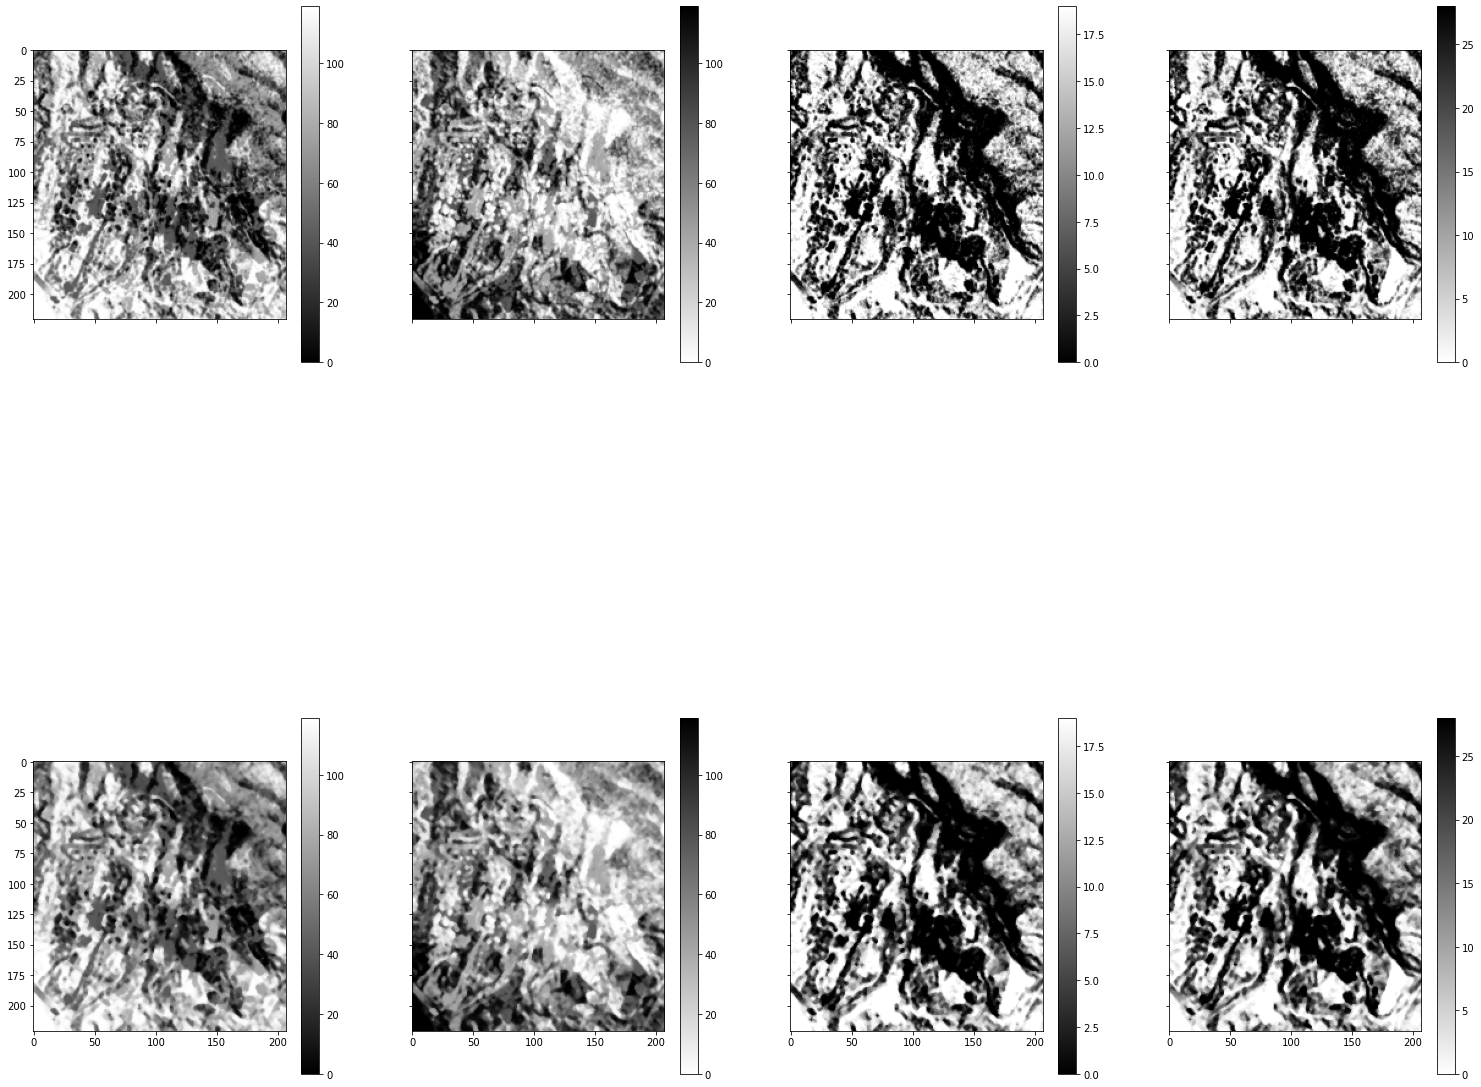

In [ ]:
# Med filtered
sum_labels_medfilt = ndimage.median_filter(sum_labels, size=3)
sum_labels_filt_medfilt = ndimage.median_filter(sum_labels_filt, size=3)
sum_labels_medfilt_yr = ndimage.median_filter(sum_labels_yr, size=3)
sum_labels_medfilt_yr_2019 = ndimage.median_filter(sum_labels_yr_2019, size=3)

# the sum of all labels over the time series - creating a change map
fig, ax = plt.subplots(2,4,figsize=(26,24),sharex=True,sharey=True)

im1 = ax[0,0].imshow(sum_labels, cmap='gray')
plt.colorbar(im1,  ax=ax[0,0], shrink=0.6)

im2 = ax[1,0].imshow(sum_labels_medfilt, cmap='gray')
plt.colorbar(im2,  ax=ax[1,0], shrink=0.6)

im3 = ax[0,1].imshow(sum_labels_filt, cmap='gray_r')
plt.colorbar(im3,  ax=ax[0,1], shrink=0.6)

im4 = ax[1,1].imshow(sum_labels_filt_medfilt, cmap='gray_r')
plt.colorbar(im4,  ax=ax[1,1], shrink=0.6)

im5 = ax[0,2].imshow(sum_labels_yr, cmap='gray')
plt.colorbar(im5,  ax=ax[0,2], shrink=0.6)

im6 = ax[1,2].imshow(sum_labels_medfilt_yr, cmap='gray')
plt.colorbar(im6,  ax=ax[1,2], shrink=0.6)

im7 = ax[0,3].imshow(sum_labels_yr_2019, cmap='gray_r')
plt.colorbar(im7,  ax=ax[0,3], shrink=0.6)

im8 = ax[1,3].imshow(sum_labels_medfilt_yr_2019, cmap='gray_r')
plt.colorbar(im8,  ax=ax[1,3], shrink=0.6);

In [ ]:
# load eopatch for one smelter
path = os.getcwd()
eopatch = EOPatch.load(os.path.join(path,smelter_name))

# eopatch array 
eopatch_arr = eopatch.data['BANDS']

# Clean up the eopatch datetimes & add to a list
times = []

for i in eopatch.timestamp:
  times.append(i.replace(tzinfo=None))

# Get the index & dates for eopatches occuring in specific year
yr = 2020
eo_time_ind =[]
eo_dates = []

for i, dates in enumerate(times):
  if dates.year == yr:
    eo_time_ind.append(i)
    eo_dates.append(dates)

eopatch_arr_yr = eopatch_arr[eo_time_ind]

# reshaping the array before plugging it to the K-means cluster
n = eopatch_arr_yr.shape[0]
x = eopatch_arr_yr.shape[1]
y = eopatch_arr_yr.shape[2]
bands = eopatch_arr_yr.shape[3]

eopatch_arr_yr_res = eopatch_arr_yr.reshape(n*x*y,bands)

# getting the statistics for each band - VV and VH
qrt1_vv, median_vv, qrt3_vv = np.percentile(eopatch_arr_yr_res[:,0],25) , np.percentile(eopatch_arr_yr_res[:,0],50) , np.percentile(eopatch_arr_yr_res[:,0],75) 
qrt1_vh, median_vh, qrt3_vh = np.percentile(eopatch_arr_yr_res[:,1],25) , np.percentile(eopatch_arr_yr_res[:,1],50) , np.percentile(eopatch_arr_yr_res[:,1],75) 

# IQR 
iqr_vv = qrt3_vv - qrt1_vv
iqr_vh = qrt3_vh - qrt1_vh

### Calculating the Min & Max 
#vv
min_vv = qrt1_vv - (1.5*iqr_vv)
max_vv = qrt3_vv + (1.5*iqr_vv)
#vh
min_vh = qrt1_vh - (1.5*iqr_vh)
max_vh = qrt3_vh + (1.5*iqr_vh)

print(min_vv, qrt1_vv, median_vv, qrt3_vv, max_vv)
print(min_vh, qrt1_vh, median_vh, qrt3_vh, max_vh)

# ignore negative min values 
# setting the upper values to max of the maximum box plot values for vv and vh
eopatch_arr_yr_res[:,0][eopatch_arr_yr_res[:,0] > max_vv] = max_vv
eopatch_arr_yr_res[:,1][eopatch_arr_yr_res[:,1] > max_vh] = max_vh

# setting the 0s to 0.00001 values for log operator to work 
eopatch_arr_yr_res[eopatch_arr_yr_res == 0] = 0.00001

# rescaling by log
eopatch_yr_res_log = np.log(eopatch_arr_yr_res)

# k-means clustering
kmeans_yr = KMeans(n_clusters=2, random_state=0).fit(eopatch_yr_res_log)

# getting the labels of the pixels 
kmeans_yr_labels = kmeans_yr.labels_

# reshaping the labelled pixels back into its original time series form
kmeans_yr_labels_ts = kmeans_yr_labels.reshape(n,x,y)

# the sum of all labels over the time series - creating a change map
sum_labels_yr_2020 = np.sum(kmeans_yr_labels_ts, axis=0)

-0.2317500114440918 0.07649999856948853 0.14270000159740448 0.28200000524520874 0.5902500152587891
-0.04484999971464276 0.013500000350177288 0.027000000700354576 0.052400000393390656 0.1107500004582107


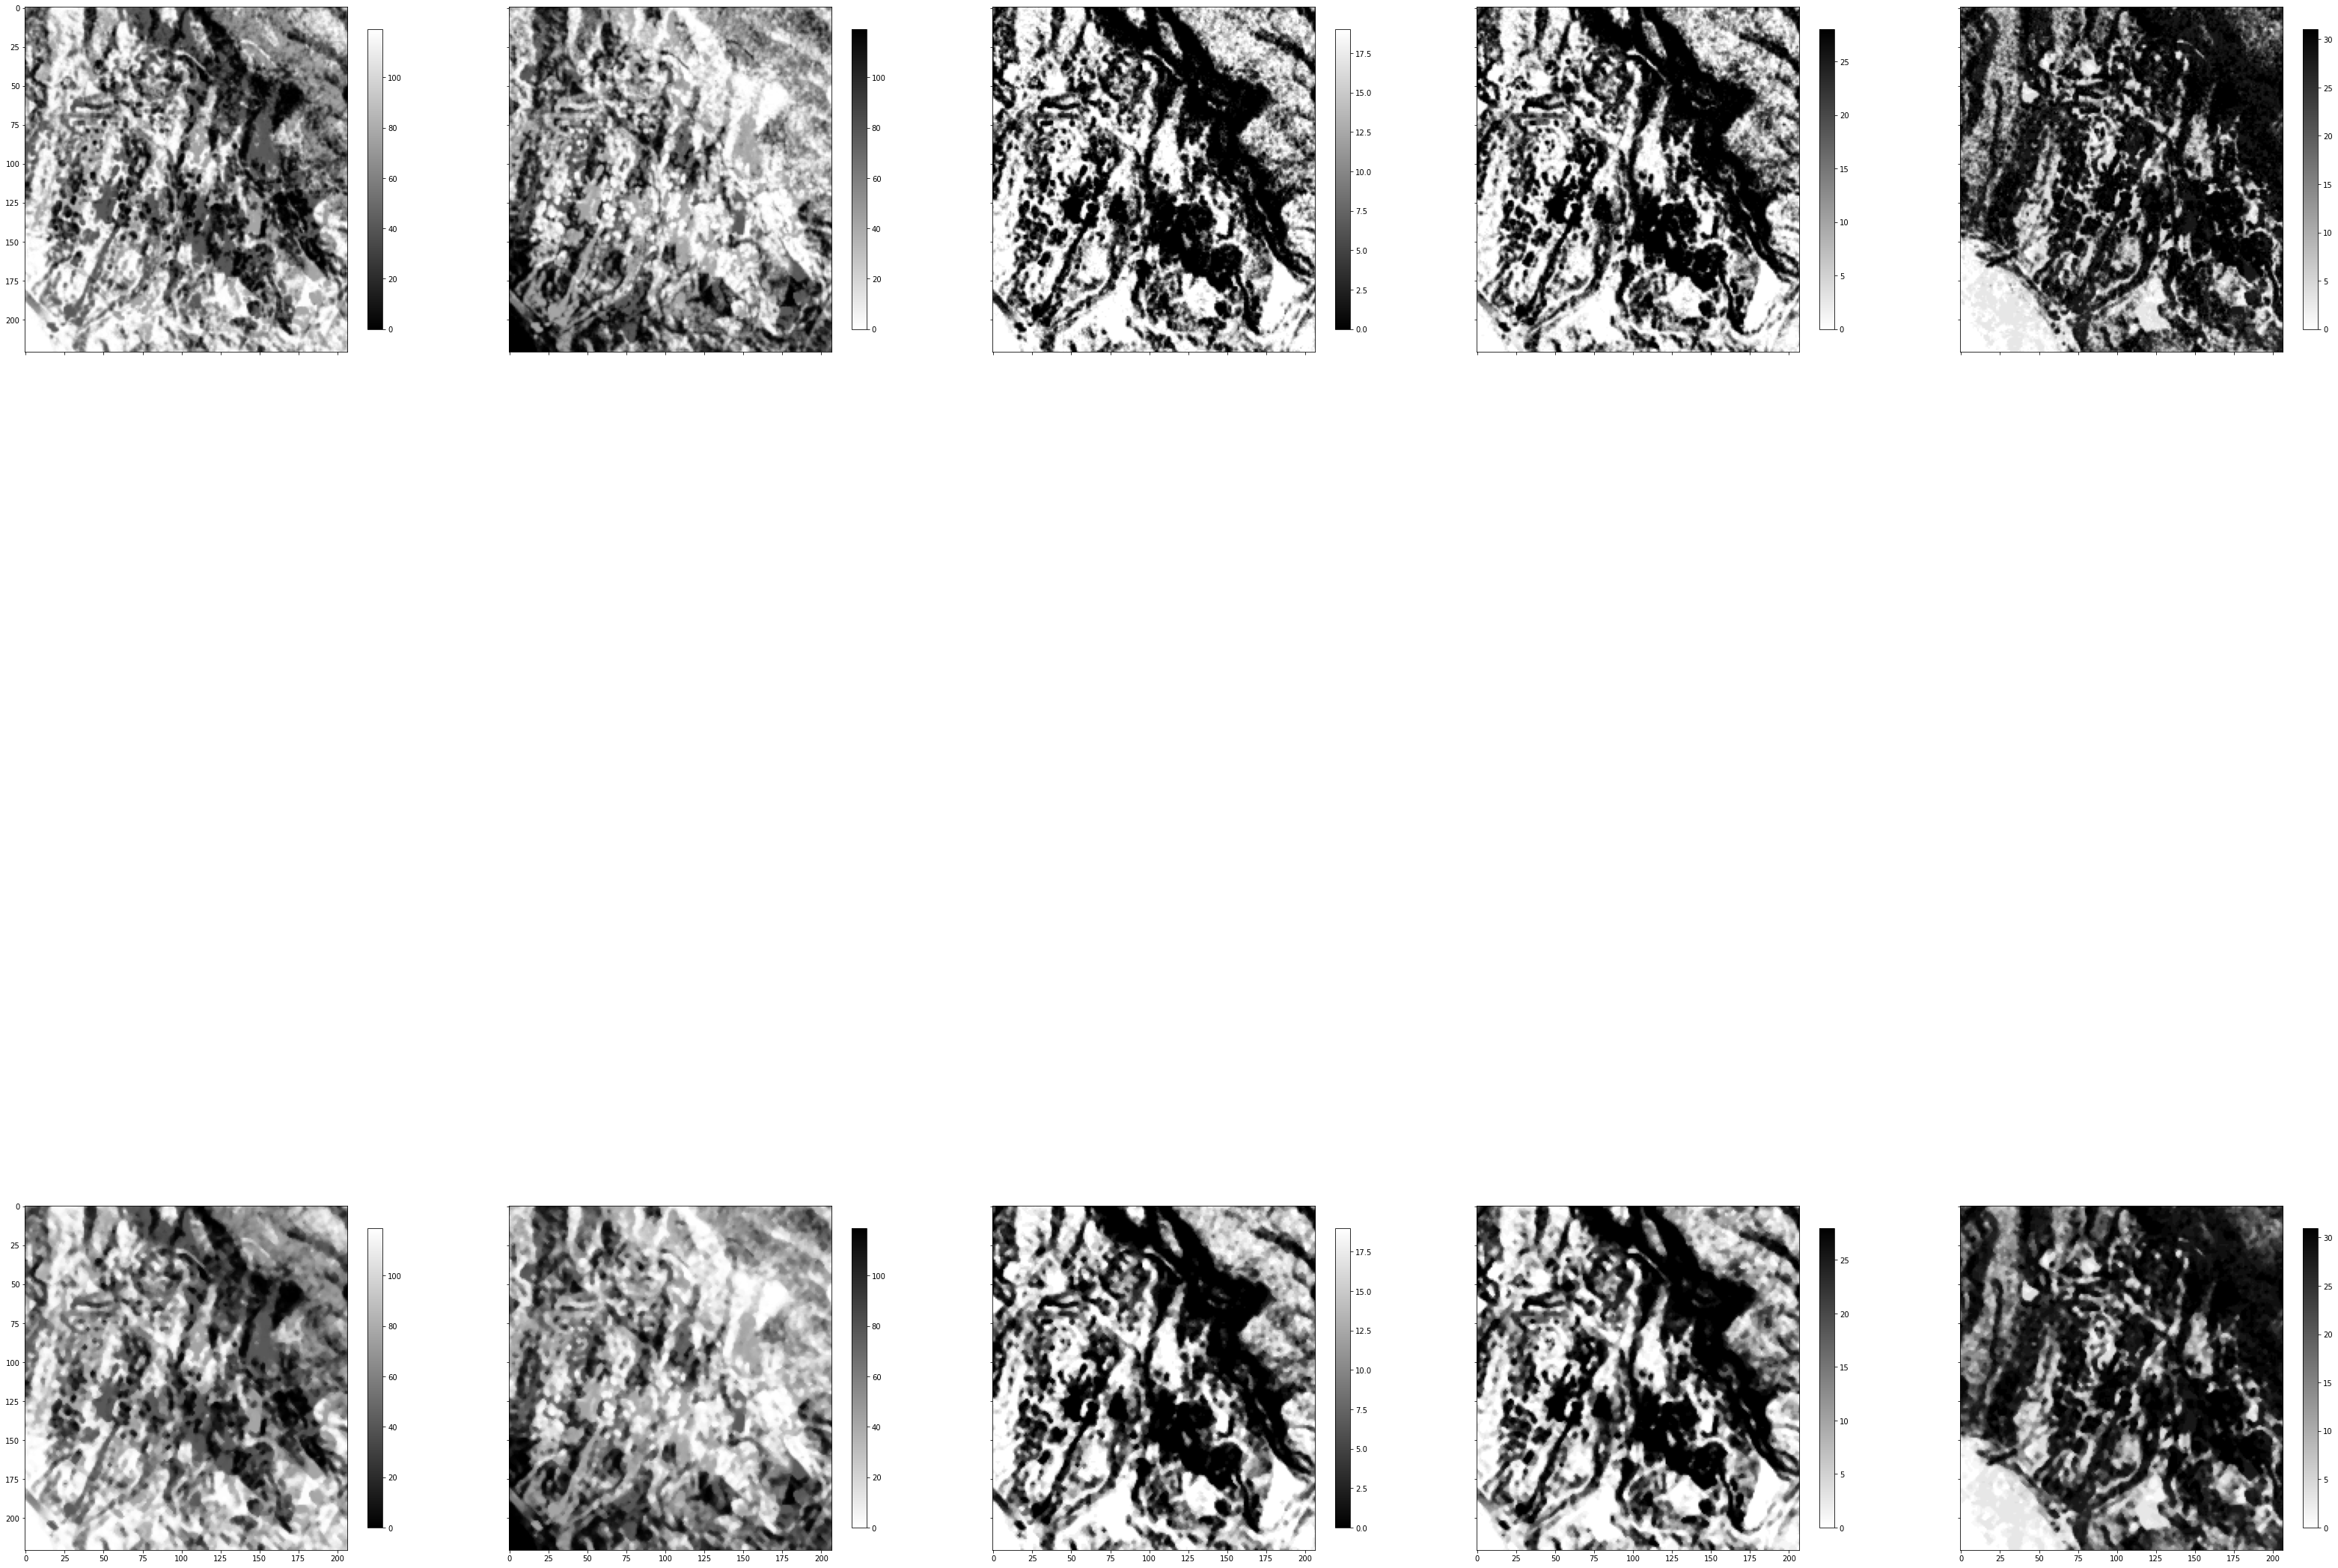

In [ ]:
# Med filtered
sum_labels_medfilt = ndimage.median_filter(sum_labels, size=3)
sum_labels_filt_medfilt = ndimage.median_filter(sum_labels_filt, size=3)
sum_labels_medfilt_yr = ndimage.median_filter(sum_labels_yr, size=3)
sum_labels_medfilt_yr_2019 = ndimage.median_filter(sum_labels_yr_2019, size=3)
sum_labels_medfilt_yr_2020 = ndimage.median_filter(sum_labels_yr_2020, size=3)

# the sum of all labels over the time series - creating a change map
fig, ax = plt.subplots(2,5,figsize=(56,54),sharex=True,sharey=True)

# All years - no percentile filtering
im1 = ax[0,0].imshow(sum_labels, cmap='gray')
plt.colorbar(im1,  ax=ax[0,0], shrink=0.3)

im2 = ax[1,0].imshow(sum_labels_medfilt, cmap='gray')
plt.colorbar(im2,  ax=ax[1,0], shrink=0.3)

# All YEARs with percentile filtering
im3 = ax[0,1].imshow(sum_labels_filt, cmap='gray_r')
plt.colorbar(im3,  ax=ax[0,1], shrink=0.3)

im4 = ax[1,1].imshow(sum_labels_filt_medfilt, cmap='gray_r')
plt.colorbar(im4,  ax=ax[1,1], shrink=0.3)

# Year 2018
im5 = ax[0,2].imshow(sum_labels_yr, cmap='gray')
plt.colorbar(im5,  ax=ax[0,2], shrink=0.3)

im6 = ax[1,2].imshow(sum_labels_medfilt_yr, cmap='gray')
plt.colorbar(im6,  ax=ax[1,2], shrink=0.3)

# Year 2019
im7 = ax[0,3].imshow(sum_labels_yr_2019, cmap='gray_r')
plt.colorbar(im7,  ax=ax[0,3], shrink=0.3)

im8 = ax[1,3].imshow(sum_labels_medfilt_yr_2019, cmap='gray_r')
plt.colorbar(im8,  ax=ax[1,3], shrink=0.3)

# Year 2020
im9 = ax[0,4].imshow(sum_labels_yr_2020, cmap='gray_r')
plt.colorbar(im9,  ax=ax[0,4], shrink=0.3)

im10 = ax[1,4].imshow(sum_labels_medfilt_yr_2020, cmap='gray_r')
plt.colorbar(im10,  ax=ax[1,4], shrink=0.3);

In [ ]:
# load eopatch for one smelter
path = os.getcwd()
eopatch = EOPatch.load(os.path.join(path,smelter_name))
print(smelter_name)
# eopatch array 
eopatch_arr = eopatch.data['BANDS']

# Clean up the eopatch datetimes & add to a list
times = []

for i in eopatch.timestamp:
  times.append(i.replace(tzinfo=None))

# Get the index & dates for eopatches occuring in specific year
yr = 2017
eo_time_ind =[]
eo_dates = []

for i, dates in enumerate(times):
  if dates.year == yr:
    eo_time_ind.append(i)
    eo_dates.append(dates)

eopatch_arr_yr = eopatch_arr[eo_time_ind]

# reshaping the array before plugging it to the K-means cluster
n = eopatch_arr_yr.shape[0]
x = eopatch_arr_yr.shape[1]
y = eopatch_arr_yr.shape[2]
bands = eopatch_arr_yr.shape[3]

eopatch_arr_yr_res = eopatch_arr_yr.reshape(n*x*y,bands)

# getting the statistics for each band - VV and VH
qrt1_vv, median_vv, qrt3_vv = np.percentile(eopatch_arr_yr_res[:,0],25) , np.percentile(eopatch_arr_yr_res[:,0],50) , np.percentile(eopatch_arr_yr_res[:,0],75) 
qrt1_vh, median_vh, qrt3_vh = np.percentile(eopatch_arr_yr_res[:,1],25) , np.percentile(eopatch_arr_yr_res[:,1],50) , np.percentile(eopatch_arr_yr_res[:,1],75) 

# IQR 
iqr_vv = qrt3_vv - qrt1_vv
iqr_vh = qrt3_vh - qrt1_vh

### Calculating the Min & Max 
#vv
min_vv = qrt1_vv - (1.5*iqr_vv)
max_vv = qrt3_vv + (1.5*iqr_vv)
#vh
min_vh = qrt1_vh - (1.5*iqr_vh)
max_vh = qrt3_vh + (1.5*iqr_vh)

print(min_vv, qrt1_vv, median_vv, qrt3_vv, max_vv)
print(min_vh, qrt1_vh, median_vh, qrt3_vh, max_vh)

# ignore negative min values 
# setting the upper values to max of the maximum box plot values for vv and vh
eopatch_arr_yr_res[:,0][eopatch_arr_yr_res[:,0] > max_vv] = max_vv
eopatch_arr_yr_res[:,1][eopatch_arr_yr_res[:,1] > max_vh] = max_vh

# setting the 0s to 0.00001 values for log operator to work 
eopatch_arr_yr_res[eopatch_arr_yr_res == 0] = 0.00001

# rescaling by log
eopatch_yr_res_log = np.log(eopatch_arr_yr_res)

# k-means clustering
kmeans_yr = KMeans(n_clusters=2, random_state=0).fit(eopatch_yr_res_log)

# getting the labels of the pixels 
kmeans_yr_labels = kmeans_yr.labels_

# reshaping the labelled pixels back into its original time series form
kmeans_yr_labels_ts = kmeans_yr_labels.reshape(n,x,y)

# the sum of all labels over the time series - creating a change map
sum_labels_yr_2017 = np.sum(kmeans_yr_labels_ts, axis=0)

hayden.json
-0.2391499988734722 0.08739999681711197 0.156700000166893 0.3050999939441681 0.6316499896347523
-0.045300002209842205 0.01769999973475933 0.032099999487400055 0.059700001031160355 0.12270000297576189


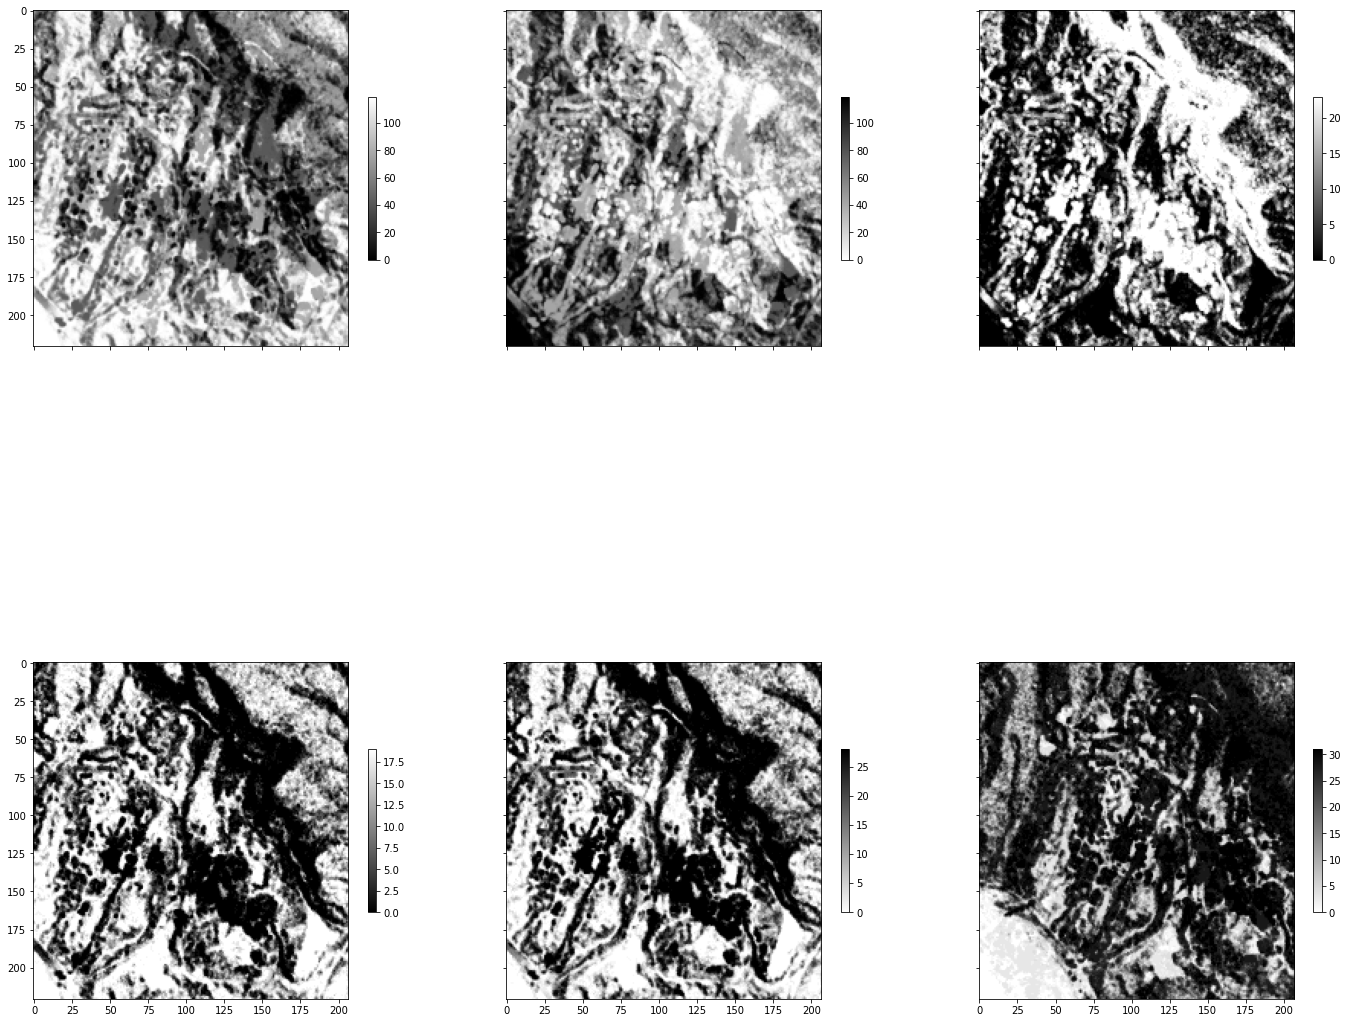

In [ ]:
# the sum of all labels over the time series - creating a change map
fig, ax = plt.subplots(2,3,figsize=(24,22),sharex=True,sharey=True)

# All years - no percentile filtering
im1 = ax[0,0].imshow(sum_labels, cmap='gray')
plt.colorbar(im1,  ax=ax[0,0], shrink=0.3)

# All YEARs with percentile filtering
im3 = ax[0,1].imshow(sum_labels_filt, cmap='gray_r')
plt.colorbar(im3,  ax=ax[0,1], shrink=0.3)

# Year 2017
im9 = ax[0,2].imshow(sum_labels_yr_2017, cmap='gray')
plt.colorbar(im9,  ax=ax[0,2], shrink=0.3)

# Year 2018
im5 = ax[1,0].imshow(sum_labels_yr, cmap='gray')
plt.colorbar(im5,  ax=ax[1,0], shrink=0.3)

# Year 2019
im7 = ax[1,1].imshow(sum_labels_yr_2019, cmap='gray_r')
plt.colorbar(im7,  ax=ax[1,1], shrink=0.3)

# Year 2020
im9 = ax[1,2].imshow(sum_labels_yr_2020, cmap='gray_r')
plt.colorbar(im9,  ax=ax[1,2], shrink=0.3);

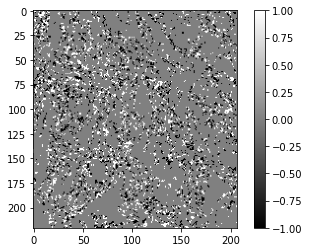

In [ ]:
# the sum of all labels over the time series - creating a change map
# sum_labels_yr_2020_part = np.sum(kmeans_yr_labels_ts[:], axis=0)

# the plot of the change map
plt.imshow(kmeans_yr_labels_ts[0] - kmeans_yr_labels_ts[1],cmap='gray')
plt.colorbar();

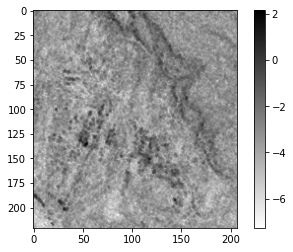

In [ ]:
# eopatch
# the plot of the change map
plt.imshow(np.log(eopatch_arr[0,...,1]),cmap='gray_r')
plt.colorbar();

# Why the percentile filtering works

In [ ]:
# load eopatch for one smelter
path = os.getcwd()
eopatch = EOPatch.load(os.path.join(path,smelter_name))

# eopatch array 
eopatch_arr = eopatch.data['BANDS']

# setting the 0s to 0.00001 values for log operator to work 
eopatch_arr[eopatch_arr == 0] = 0.00001

# get array details
n = eopatch_arr.shape[0]
x = eopatch_arr.shape[1]
y = eopatch_arr.shape[2]
bands = eopatch_arr.shape[3]

# reshaping
eopatch_arr_res = eopatch_arr.reshape( n*x*y,bands)

# rescaling by log
eopatch_log = np.log(eopatch_arr_res)

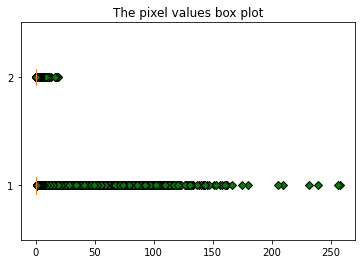

In [ ]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('The pixel values box plot')
ax1.boxplot(eopatch_arr_res, vert=False, flierprops=green_diamond);

# The green marks are all outliers 
# We can barely see the IQR where the median is around 0.1 and 0.2 for VH and VV bands.
# The 25th percentile and 75th percentiles can also barely be seen - most data values lie within that range.
# Hence we can set the other 'outlier' points in green to at least equal the upper percentile of the box plot 
# We can re-scale them in other ways too since they are not all the same 

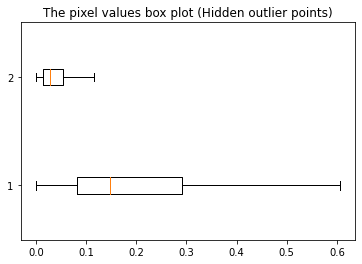

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('The pixel values box plot (Hidden outlier points)')
ax1.boxplot(eopatch_arr_res, vert=False, showfliers=False);

# Dates of satellite images

In [ ]:
# The average number of days between images is 12
np.diff(eopatch.timestamp)[:10] , np.mean(np.diff(eopatch.timestamp)) , np.min(np.diff(eopatch.timestamp))

(array([datetime.timedelta(days=407, seconds=86396),
        datetime.timedelta(days=84, seconds=21),
        datetime.timedelta(days=137, seconds=86349),
        datetime.timedelta(days=23, seconds=86399),
        datetime.timedelta(days=23, seconds=86399),
        datetime.timedelta(days=24), datetime.timedelta(days=12),
        datetime.timedelta(days=12),
        datetime.timedelta(days=24, seconds=1),
        datetime.timedelta(days=12)], dtype=object),
 datetime.timedelta(days=19, seconds=23430, microseconds=449153),
 datetime.timedelta(days=11, seconds=86399))

In [ ]:
# What is the avr number of days between satellite images?

days = [] 
ndiff = np.diff(eopatch.timestamp)
 
for i in range(len(eopatch.timestamp)-1):
  days.append(ndiff[i].days)

np.mean(days)

19.10169491525424

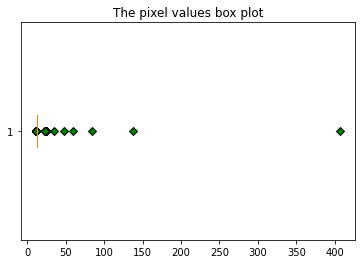

In [ ]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig1, ax1 = plt.subplots()
ax1.set_title('The pixel values box plot')
ax1.boxplot(days, vert=False, flierprops=green_diamond);

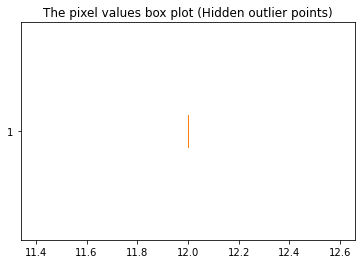

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('The pixel values box plot (Hidden outlier points)')
ax1.boxplot(days, vert=False, showfliers=False);

In [ ]:
# What are the values of the dates that do not have 12 day difference?

# get the index of the array
a = np.where(np.array(days) !=12)[0].tolist()

# Get the actual date differences from the index
lst = []

for i in range(len(a)):
  lst.append(days[a[i]])

np.unique(lst)

array([ 11,  23,  24,  35,  48,  60,  84, 137, 407])

# ALL DATA clustered

In [ ]:
# load eopatch for one smelter
path = os.getcwd()
eopatch = EOPatch.load(os.path.join(path,smelter_name))

# eopatch array 
eopatch_arr = eopatch.data['BANDS']

# setting the 0s to 0.00001 values for log operator to work 
eopatch_arr[eopatch_arr == 0] = 0.00001

# get array details
n = eopatch_arr.shape[0]
x = eopatch_arr.shape[1]
y = eopatch_arr.shape[2]
bands = eopatch_arr.shape[3]

# reshaping
eopatch_arr_res = eopatch_arr.reshape(n*x*y,bands)

# getting the statistics for each band - VV and VH
qrt1_vv, median_vv, qrt3_vv = np.percentile(eopatch_arr_res[:,0],25) , np.percentile(eopatch_arr_res[:,0],50) , np.percentile(eopatch_arr_res[:,0],75) 
qrt1_vh, median_vh, qrt3_vh = np.percentile(eopatch_arr_res[:,1],25) , np.percentile(eopatch_arr_res[:,1],50) , np.percentile(eopatch_arr_res[:,1],75) 

# IQR 
iqr_vv = qrt3_vv - qrt1_vv
iqr_vh = qrt3_vh - qrt1_vh

### Calculating the Min & Max 
#vv
min_vv = qrt1_vv - (1.5*iqr_vv)
max_vv = qrt3_vv + (1.5*iqr_vv)
#vh
min_vh = qrt1_vh - (1.5*iqr_vh)
max_vh = qrt3_vh + (1.5*iqr_vh)

print(min_vv, qrt1_vv, median_vv, qrt3_vv, max_vv)
print(min_vh, qrt1_vh, median_vh, qrt3_vh, max_vh)

# ignore negative min values 
# setting the upper values to max of the maximum box plot values for vv and vh
eopatch_arr_res[:,0][eopatch_arr_res[:,0] > max_vv] = max_vv
eopatch_arr_res[:,1][eopatch_arr_res[:,1] > max_vh] = max_vh

# checking it works
# np.max(eopatch_arr_res[:,0]), np.max(eopatch_arr_res[:,1])

# rescaling by log
eopatch_log_filt = np.log(eopatch_arr_res)

# k-means clustering
kmeans_filt = KMeans(n_clusters=2, random_state=0).fit(eopatch_log_filt)

# getting the labels of the pixels 
eopatch_kmeans_labels_filt = kmeans_filt.labels_

# reshaping the labelled pixels back into its original time series form
eopatch_kmeans_ts_filt = eopatch_kmeans_labels_filt.reshape(n,x,y)

# the sum of all labels over the time series - creating a change map
sum_labels_filt = np.sum(eopatch_kmeans_ts_filt, axis=0)

-0.23394998908042908 0.0812000036239624 0.14869999885559082 0.2912999987602234 0.6064499914646149
-0.044549998827278614 0.015300000086426735 0.029100000858306885 0.0551999993622303 0.11504999827593565


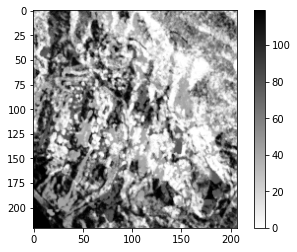

In [ ]:
# the plot of the change map
plt.imshow(sum_labels_filt,cmap='gray_r')
plt.colorbar();

89 29


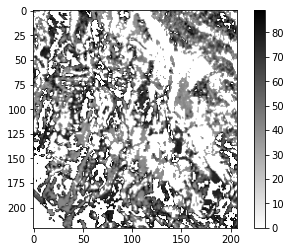

In [ ]:
# setting the pixel values over the 80th and under the 20th percentile to 0 to see the grey ares 

# copy of sum
sum_labels_copy = sum_labels_filt.copy()

top_per , bottom_perc = int(n*0.75) , int(n*0.25)
print(top_per , bottom_perc)

# setting the values to 0/zoo
sum_labels_copy[sum_labels_copy  > top_per ] = 0
sum_labels_copy[sum_labels_copy  < bottom_perc ] = 0

# the plot of the change map
plt.imshow(sum_labels_copy,cmap='gray_r')
plt.colorbar();

In [ ]:
# reshape the summed and filtered values 
sum_labels_reshaped = sum_labels_copy.reshape(-1,1)

# get the index values for values that are greater than 0 (AoI pixel positions)
aoi_ind = [ind for ind, val in enumerate(sum_labels_reshaped) if val > 0]

# AoI pixels as a % of the total image pixels
print(len(aoi_ind) / sum_labels_reshaped.shape[0])

eopatch_lbl_ts_diff = np.diff(eopatch_kmeans_ts_filt, axis=0)

eopatch_lbl_ts_diff_aoi = np.zeros((len(aoi_ind), eopatch_lbl_ts_diff.shape[0]))

# filtering the AoI for the 45 (differenced) time series 
for i in range(eopatch_lbl_ts_diff.shape[0]):

  eopatch_lbl_ts_diff_aoi[:,i] = eopatch_lbl_ts_diff[i].reshape(-1,1)[aoi_ind].flatten()  # (2030,)

print(eopatch_kmeans_ts_filt.shape, eopatch_lbl_ts_diff.shape, eopatch_lbl_ts_diff_aoi.shape)

ts = eopatch_lbl_ts_diff_aoi.shape[1]

no_change_ts = np.zeros(ts)

pos_change_ts = np.zeros(ts)

neg_change_ts = np.zeros(ts)

for i in range(ts):

  no_change_ts[i] = eopatch_lbl_ts_diff_aoi[:,i][eopatch_lbl_ts_diff_aoi[:,i] == 0].size

  pos_change_ts[i] = eopatch_lbl_ts_diff_aoi[:,i][eopatch_lbl_ts_diff_aoi[:,i] == 1].size

  neg_change_ts[i] = eopatch_lbl_ts_diff_aoi[:,i][eopatch_lbl_ts_diff_aoi[:,i] == -1].size


0.5583098345246683
(119, 221, 207) (118, 221, 207) (25541, 118)


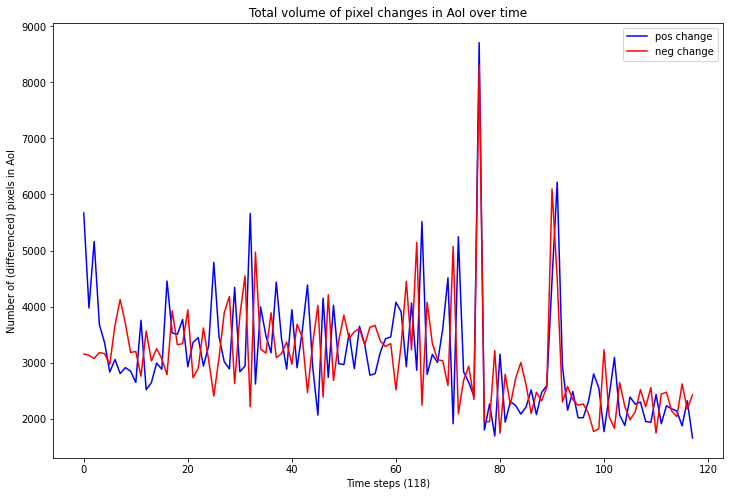

In [ ]:
fig = plt.figure(figsize=(12,8))

# plt.plot(no_change_ts, 'green', label='no change')
plt.plot(pos_change_ts, 'blue', label='pos change')
plt.plot(neg_change_ts, 'red', label='neg change')
plt.legend()

plt.title('Total volume of pixel changes in AoI over time')
plt.xlabel('Time steps ({})'.format(ts))
plt.ylabel('Number of (differenced) pixels in AoI');

In [ ]:
import scipy.stats as stats

In [ ]:
stats.pearsonr(pos_change_ts, neg_change_ts) # Output: Pearson's corr coef & two-tailed p-value

### Output analysis:
# We see that the fist value is closer to -1 than 0.
# The p-value is quite small << 0.01 so  there is some evidece to suggest that the two time series are negatively correlated.

(0.37426230763342855, 2.9794878408409507e-05)

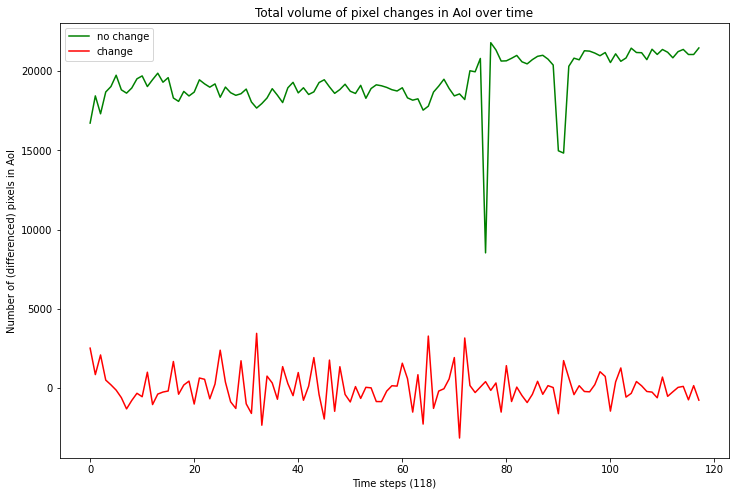

In [ ]:
# What if we take the difference between the two negative & positive time series?
# The since if there is a + change would negatively correlate with a negative change 
# i.e. if pos. pixels +1 then neg. pixels would -1
# then taking the difference could theoretially give only the 'true' change + noise

fig = plt.figure(figsize=(12,8))

plt.plot(no_change_ts, 'green', label='no change')

# Difference the negative and positive changes since the images can be misalligned
plt.plot(abs(pos_change_ts-neg_change_ts), 'red', label='change')
plt.legend()

plt.title('Total volume of pixel changes in AoI over time')
plt.xlabel('Time steps ({})'.format(ts))
plt.ylabel('Number of (differenced) pixels in AoI');

In [ ]:
stats.pearsonr((pos_change_ts-neg_change_ts), no_change_ts)

# The no change pixels are uncorrelated with the changed pixels 
# since the p-value > 0.01 and corr coef < 0.5

(-0.14202931062051047, 0.1249809434845155)

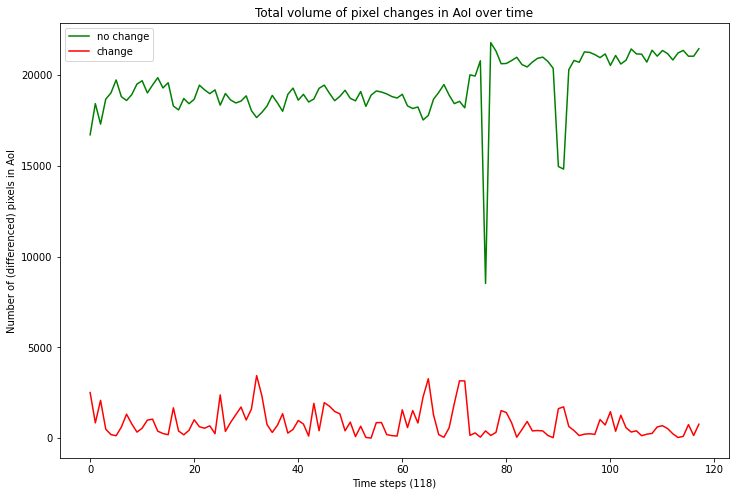

In [ ]:
# What if we take the difference between the two negative & positive time series?
# The since if there is a + change would negatively correlate with a negative change 
# i.e. if pos. pixels +1 then neg. pixels would -1
# then taking the difference could theoretially give only the 'true' change + noise

fig = plt.figure(figsize=(12,8))

plt.plot(no_change_ts, 'green', label='no change')

# Difference the negative and positive changes since the images can be misalligned
plt.plot(abs(pos_change_ts-neg_change_ts), 'red', label='change')
plt.legend()

plt.title('Total volume of pixel changes in AoI over time')
plt.xlabel('Time steps ({})'.format(ts))
plt.ylabel('Number of (differenced) pixels in AoI');

# Get rid of anything not equal to the avr number of days the images are taken

In [ ]:
# load eopatch for one smelter
path = os.getcwd()
eopatch = EOPatch.load(os.path.join(path,smelter_name))

# eopatch array 
eopatch_arr = eopatch.data['BANDS']

########################################### Deleting the non 12 day period images
# What is the avr number of days between satellite images?

days = [] 
ndiff = np.diff(eopatch.timestamp)
 
# Making a list with the difference in satellite images
for i in range(len(eopatch.timestamp)-1):
  days.append(ndiff[i].days)

# Get the index of the array where the differenced dates are not 12 as expected from this satelite 
a = np.where(np.array(days) !=12)[0].tolist()

# drop the images following the index since im1 - im2 where im2 is the one we want to drop 
ind_img = list(map(lambda x:x+1, a))

# getting rid of the images that have time difference not equal to 12 days
eopatch_arr_wdates = np.delete(eopatch_arr, ind_img, 0)

########################################### Set 0 to 0.0000...1 and any outliers to upper box plot %

# setting the 0s to 0.00001 values for log operator to work 
eopatch_arr_wdates[eopatch_arr_wdates == 0] = 0.00001

# get array details
n = eopatch_arr_wdates.shape[0]
x = eopatch_arr_wdates.shape[1]
y = eopatch_arr_wdates.shape[2]
bands = eopatch_arr_wdates.shape[3]

# reshaping
eopatch_arr_res = eopatch_arr_wdates.reshape(n*x*y,bands)

# getting the statistics for each band - VV and VH
qrt1_vv, median_vv, qrt3_vv = np.percentile(eopatch_arr_res[:,0],25) , np.percentile(eopatch_arr_res[:,0],50) , np.percentile(eopatch_arr_res[:,0],75) 
qrt1_vh, median_vh, qrt3_vh = np.percentile(eopatch_arr_res[:,1],25) , np.percentile(eopatch_arr_res[:,1],50) , np.percentile(eopatch_arr_res[:,1],75) 

# IQR 
iqr_vv = qrt3_vv - qrt1_vv
iqr_vh = qrt3_vh - qrt1_vh

### Calculating the Min & Max 
#vv
min_vv = qrt1_vv - (1.5*iqr_vv)
max_vv = qrt3_vv + (1.5*iqr_vv)
#vh
min_vh = qrt1_vh - (1.5*iqr_vh)
max_vh = qrt3_vh + (1.5*iqr_vh)

# ignore negative min values 
# setting the upper values to max of the maximum box plot values for vv and vh
eopatch_arr_res[:,0][eopatch_arr_res[:,0] > max_vv] = max_vv
eopatch_arr_res[:,1][eopatch_arr_res[:,1] > max_vh] = max_vh

########################################### Log rescale & k-means clustering

# rescaling by log
eopatch_log_filt = np.log(eopatch_arr_res)

# k-means clustering
kmeans_filt = KMeans(n_clusters=2, random_state=0).fit(eopatch_log_filt)

########################################### Get labels & reshape data 

# getting the labels of the pixels 
eopatch_kmeans_labels_filt = kmeans_filt.labels_

# reshaping the labelled pixels back into its original time series form
eopatch_kmeans_ts_filt = eopatch_kmeans_labels_filt.reshape(n,x,y)

# the sum of all labels over the time series - creating a change map
sum_labels_filt = np.sum(eopatch_kmeans_ts_filt, axis=0)

66 22
0.5552058058451921
(88, 221, 207) (87, 221, 207) (25399, 87)


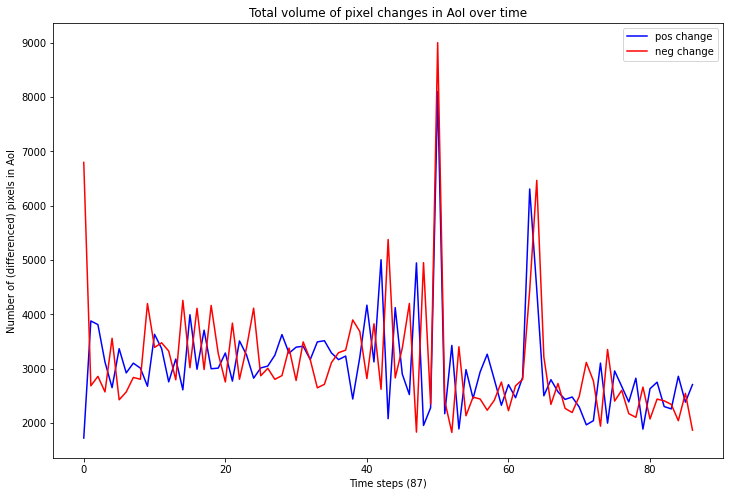

In [ ]:
########################################################## Bright & dim pixels set to 0
# copy of sum
sum_labels_copy = sum_labels_filt.copy()

### setting the pixel values over the 80th and under the 20th percentile to 0 to see the grey ares 
top_per , bottom_perc = int(n*0.75) , int(n*0.25)
print(top_per , bottom_perc)

# setting the values to 0
sum_labels_copy[sum_labels_copy  > top_per ] = 0
sum_labels_copy[sum_labels_copy  < bottom_perc ] = 0

# reshape the summed and filtered values 
sum_labels_reshaped = sum_labels_copy.reshape(-1,1)

########################################################## FIND AOI 
# get the index values for values that are greater than 0 (AoI pixel positions)
aoi_ind = [ind for ind, val in enumerate(sum_labels_reshaped) if val > 0]

# AoI pixels as a % of the total image pixels
print(len(aoi_ind) / sum_labels_reshaped.shape[0])

########################################################## AOI time series only

eopatch_lbl_ts_diff = np.diff(eopatch_kmeans_ts_filt, axis=0)

eopatch_lbl_ts_diff_aoi = np.zeros((len(aoi_ind), eopatch_lbl_ts_diff.shape[0]))

# filtering the AoI for the (differenced) time series 
for i in range(eopatch_lbl_ts_diff.shape[0]):

  eopatch_lbl_ts_diff_aoi[:,i] = eopatch_lbl_ts_diff[i].reshape(-1,1)[aoi_ind].flatten()  # (2030,)

print(eopatch_kmeans_ts_filt.shape, eopatch_lbl_ts_diff.shape, eopatch_lbl_ts_diff_aoi.shape)

########################################################## Differenced AOI - classifying pixels
ts = eopatch_lbl_ts_diff_aoi.shape[1]

no_change_ts = np.zeros(ts)

pos_change_ts = np.zeros(ts)

neg_change_ts = np.zeros(ts)

for i in range(ts):

  no_change_ts[i] = eopatch_lbl_ts_diff_aoi[:,i][eopatch_lbl_ts_diff_aoi[:,i] == 0].size

  pos_change_ts[i] = eopatch_lbl_ts_diff_aoi[:,i][eopatch_lbl_ts_diff_aoi[:,i] == 1].size

  neg_change_ts[i] = eopatch_lbl_ts_diff_aoi[:,i][eopatch_lbl_ts_diff_aoi[:,i] == -1].size

########################################################## Plotting the image
fig = plt.figure(figsize=(12,8))
#pos_change_ts = pos_change_ts - 1000
#neg_change_ts = neg_change_ts - 1000
#pos_change_ts[pos_change_ts < 2000] = 2000
#neg_change_ts[neg_change_ts < 2000] = 2000
plt.plot(pos_change_ts, 'blue', label='pos change')
plt.plot(neg_change_ts, 'red', label='neg change')
plt.legend()

plt.title('Total volume of pixel changes in AoI over time')
plt.xlabel('Time steps ({})'.format(ts))
plt.ylabel('Number of (differenced) pixels in AoI');

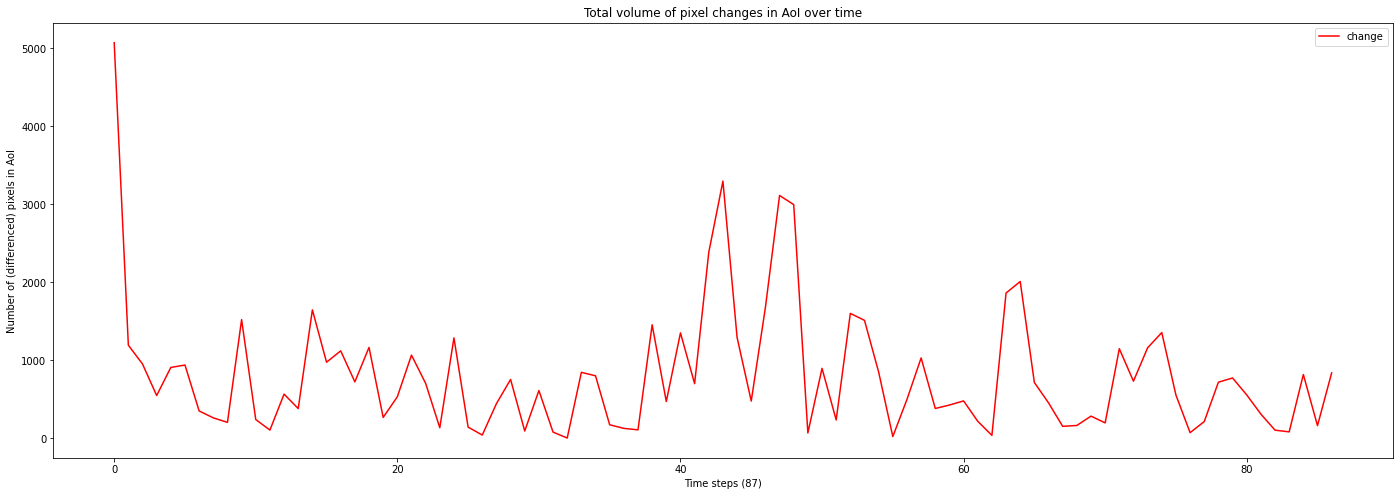

In [ ]:
# What if we take the difference between the two negative & positive time series?
# The since if there is a + change would negatively correlate with a negative change 
# i.e. if pos. pixels +1 then neg. pixels would -1
# then taking the difference could theoretially give only the 'true' change + noise

fig = plt.figure(figsize=(24,8))

#plt.plot(no_change_ts, 'green', label='no change')

# Difference the negative and positive changes since the images can be misalligned
line = abs(pos_change_ts-neg_change_ts) # - 500
#line[line < 0] = 0
plt.plot(line, 'red', label='change')
plt.legend()

plt.title('Total volume of pixel changes in AoI over time')
plt.xlabel('Time steps ({})'.format(ts))
plt.ylabel('Number of (differenced) pixels in AoI');

# Adding SAVANT data for estimating correlation between the time series we have vs. savant ts

## The Savant dataframe cleaning

In [ ]:
ls

daye.json/    individual_smelter_data.csv  onsan_1.json/
hayden.json/  onahama.json/                Virtue_Dragon.json/


In [ ]:
df = pd.read_csv('individual_smelter_data.csv')
df.head()

Smelter name  Smelter ID Smelter type  ... Raw index score  Cloud pct  Data age
0  Olympic Dam         631           cu  ...             2.0      0.119         1
1  Olympic Dam         631           cu  ...             2.0      0.119         2
2  Olympic Dam         631           cu  ...             2.0      0.119         3
3  Olympic Dam         631           cu  ...             2.0      0.119         4
4  Olympic Dam         631           cu  ...             2.0      0.119         5

[5 rows x 14 columns]

In [ ]:
# df.columns

In [ ]:
#### Hayden smelter only 

# Getting data for specific smelter & turning the dates into datetime
dfH = df[df['Smelter name'] == 'Hayden'] 
dfH['Capture date'] = pd.to_datetime(dfH['Capture date'])
dfH.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1950 entries, 124738 to 126687
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Smelter name         1950 non-null   object        
 1   Smelter ID           1950 non-null   int64         
 2   Smelter type         1950 non-null   object        
 3   Capture date         1950 non-null   datetime64[ns]
 4   State                1950 non-null   int64         
 5   Activity dispersion  1950 non-null   float64       
 6   Capacity             1950 non-null   int64         
 7   Hotspots             1950 non-null   int64         
 8   Low count            1950 non-null   int64         
 9   Medium count         1950 non-null   int64         
 10  High count           1950 non-null   int64         
 11  Raw index score      1950 non-null   float64       
 12  Cloud pct            1950 non-null   float64       
 13  Data age             1950 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
dfH['Capture date'].min(), dfH['Capture date'].max()

(Timestamp('2016-01-03 00:00:00'), Timestamp('2021-12-06 00:00:00'))

In [ ]:
#### The data from Savant 

## Get the dates and activity dispersion into a tuple 
# getting the dates only from the datetime array and creating the label arrays 
dates_arr = np.array([d.date() for d in dfH['Capture date']])


# activity_arr = dfH['Activity dispersion'].to_numpy()

activity_arr = dfH['State'].to_numpy()

# make a list of sorted tuples by dates for the for-loop 
dt_act_list = [(dates_arr[i],activity_arr[i]) for i in np.argsort(dates_arr)]
dt_act_list[:5] , len(dt_act_list)

([(datetime.date(2016, 1, 3), 1),
  (datetime.date(2016, 1, 4), 1),
  (datetime.date(2016, 1, 5), 1),
  (datetime.date(2016, 1, 6), 1),
  (datetime.date(2016, 1, 7), 1)],
 1950)

----

In [ ]:
#### Eopatch dates

# Get rid of the tzinfo
eo_times = [i.replace(tzinfo=None).date() for i in eopatch.timestamp]
eo_times[:3] , len(eo_times) 

([datetime.date(2015, 3, 24),
  datetime.date(2016, 5, 5),
  datetime.date(2016, 7, 28)],
 119)

----

In [ ]:
np.median(np.diff(dates_arr)) # one day diff in df mostly

datetime.timedelta(days=1)

In [ ]:
np.median(np.diff(eo_times)) # 12 days diff mostly

datetime.timedelta(days=12)

## Filtering the df dates closest to the eopatch image capture dates

In [ ]:
# The for loop with sorted dates and labels from both the eopatch and dataframe with smelter states

valid_timestamp = []
valid_activity = []
valid_ind = []
eo_timestamp = []

for i, eopatch_timestamp in enumerate(eo_times):

  for (df_timestamp, df_state) in dt_act_list:

    # the differences between times 
    diff_dates = eopatch_timestamp - df_timestamp
    diff_days = diff_dates.days

    if abs(diff_days) ==0: # thresh 1 days - min number of differences for df differences is 1 (so that no labels are repeated) 
      eo_timestamp.append(eopatch_timestamp)
      valid_timestamp.append(df_timestamp)
      valid_activity.append(df_state)
      valid_ind.append(i)

captures = eopatch_arr[valid_ind]

print(eopatch_arr.shape)
print(captures.shape) # ## The eopatches/images time series. 

# eo_timestamp # the timestamps for the eopatch 
# valid_timestamp # the valid timestamps from the dataframe also recorded

# valid_ind # the index for the correct eopatches
valid_activity[:5] # the states- on/off for the valid eopatches

(119, 221, 207, 2)
(115, 221, 207, 2)


[1, 1, 1, 1, 1]

## The clustering 

In [ ]:
########################################### Using the Capture image arrays instead
# eopatch_arr.shape
# captures.shape # ## The eopatches/images time series. 

# valid_ind # the index for the correct eopatches
# valid_activity # the states- on/off for the valid eopatches 

# eo_timestamp # the timestamps for the eopatch 
# valid_timestamp # the valid timestamps from the dataframe also recorded

########################################### Set 0 to 0.0000...1 and any outliers to upper box plot %

# setting the 0s to 0.00001 values for log operator to work 
captures[captures == 0] = 0.0001

# get array details
n = captures.shape[0]
x = captures.shape[1]
y = captures.shape[2]
bands = captures.shape[3]

# reshaping
eopatch_arr_res = captures.reshape(n*x*y,bands)

# getting the statistics for each band - VV and VH
qrt1_vv, median_vv, qrt3_vv = np.percentile(eopatch_arr_res[:,0],25) , np.percentile(eopatch_arr_res[:,0],50) , np.percentile(eopatch_arr_res[:,0],75) 
qrt1_vh, median_vh, qrt3_vh = np.percentile(eopatch_arr_res[:,1],25) , np.percentile(eopatch_arr_res[:,1],50) , np.percentile(eopatch_arr_res[:,1],75) 

# IQR 
iqr_vv = qrt3_vv - qrt1_vv
iqr_vh = qrt3_vh - qrt1_vh

### Calculating the Min & Max 
#vv
min_vv = qrt1_vv - (1.5*iqr_vv)
max_vv = qrt3_vv + (1.5*iqr_vv)
#vh
min_vh = qrt1_vh - (1.5*iqr_vh)
max_vh = qrt3_vh + (1.5*iqr_vh)

# ignore negative min values 
# setting the upper values to max of the maximum box plot values for vv and vh
eopatch_arr_res[:,0][eopatch_arr_res[:,0] > max_vv] = max_vv
eopatch_arr_res[:,1][eopatch_arr_res[:,1] > max_vh] = max_vh

########################################### Log rescale & k-means clustering

# rescaling by log
eopatch_log_filt = np.log(eopatch_arr_res)

# k-means clustering
kmeans_filt = KMeans(n_clusters=2, random_state=0).fit(eopatch_log_filt)

########################################### Get labels & reshape data 

# getting the labels of the pixels 
eopatch_kmeans_labels_filt = kmeans_filt.labels_

# reshaping the labelled pixels back into its original time series form
eopatch_kmeans_ts_filt = eopatch_kmeans_labels_filt.reshape(n,x,y)

# the sum of all labels over the time series - creating a change map
sum_labels_filt = np.sum(eopatch_kmeans_ts_filt, axis=0)

## The AOI & time series for the captures

63 51
0.10995256519553195
(115, 221, 207) (114, 221, 207) (5030, 114)


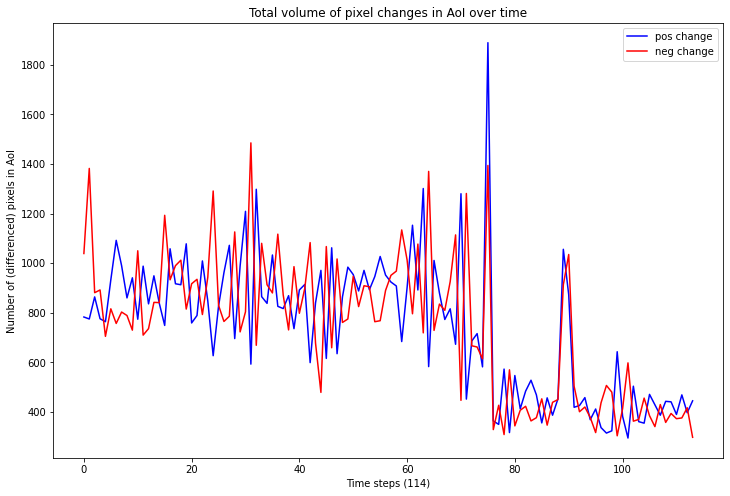

In [ ]:
########################################################## Bright & dim pixels set to 0
# copy of sum
sum_labels_copy = sum_labels_filt.copy()

### setting the pixel values over the 80th and under the 20th percentile to 0 to see the grey ares 
top_per , bottom_perc = int(n*0.55) , int(n*0.45)
print(top_per , bottom_perc)

# setting the values to 0
sum_labels_copy[sum_labels_copy  > top_per ] = 0
sum_labels_copy[sum_labels_copy  < bottom_perc ] = 0

# reshape the summed and filtered values 
sum_labels_reshaped = sum_labels_copy.reshape(-1,1)

########################################################## FIND AOI 
# get the index values for values that are greater than 0 (AoI pixel positions)
aoi_ind = [ind for ind, val in enumerate(sum_labels_reshaped) if val > 0]

# AoI pixels as a % of the total image pixels
print(len(aoi_ind) / sum_labels_reshaped.shape[0])

########################################################## AOI time series only

eopatch_lbl_ts_diff = np.diff(eopatch_kmeans_ts_filt, axis=0)

eopatch_lbl_ts_diff_aoi = np.zeros((len(aoi_ind), eopatch_lbl_ts_diff.shape[0]))

# filtering the AoI for the (differenced) time series 
for i in range(eopatch_lbl_ts_diff.shape[0]):

  eopatch_lbl_ts_diff_aoi[:,i] = eopatch_lbl_ts_diff[i].reshape(-1,1)[aoi_ind].flatten()  # (2030,)

print(eopatch_kmeans_ts_filt.shape, eopatch_lbl_ts_diff.shape, eopatch_lbl_ts_diff_aoi.shape)

########################################################## Differenced AOI - classifying pixels
ts = eopatch_lbl_ts_diff_aoi.shape[1]

no_change_ts = np.zeros(ts)

pos_change_ts = np.zeros(ts)

neg_change_ts = np.zeros(ts)

for i in range(ts):

  no_change_ts[i] = eopatch_lbl_ts_diff_aoi[:,i][eopatch_lbl_ts_diff_aoi[:,i] == 0].size

  pos_change_ts[i] = eopatch_lbl_ts_diff_aoi[:,i][eopatch_lbl_ts_diff_aoi[:,i] == 1].size

  neg_change_ts[i] = eopatch_lbl_ts_diff_aoi[:,i][eopatch_lbl_ts_diff_aoi[:,i] == -1].size

########################################################## Plotting the image
fig = plt.figure(figsize=(12,8))


### I don't recommend this Tim hahaha
#pos_change_ts = pos_change_ts - 1000 
#neg_change_ts = neg_change_ts - 1000
#pos_change_ts[pos_change_ts < 2000] = 2000
#neg_change_ts[neg_change_ts < 2000] = 2000


plt.plot(pos_change_ts, 'blue', label='pos change')
plt.plot(neg_change_ts, 'red', label='neg change')
plt.legend()

plt.title('Total volume of pixel changes in AoI over time')
plt.xlabel('Time steps ({})'.format(ts))
plt.ylabel('Number of (differenced) pixels in AoI');

## Comparing the valid_activity and pos & neg change time series

In [ ]:
from scipy import stats

In [ ]:
## The state/activity array is longer than the differenced images in this case. 
## So we can take the activity starting on the date and ending a date before. 

act_new = np.array(valid_activity)[:-1]

## Pixel changes
print(stats.pearsonr((pos_change_ts), act_new))
print(stats.pearsonr((neg_change_ts), act_new))

## Logged 
print(stats.pearsonr(np.log(pos_change_ts), act_new))
print(stats.pearsonr(np.log(neg_change_ts), act_new))

## Differences
print(stats.pearsonr((pos_change_ts-neg_change_ts), act_new))
print(stats.pearsonr(abs(pos_change_ts-neg_change_ts), act_new))

(0.34557343481837677, 0.00016604756546734984)
(0.481984766161222, 5.648852615437481e-08)
(0.4126711640294857, 5.052240167837264e-06)
(0.5106765683971022, 6.441519291320609e-09)
(-0.15063165959951164, 0.10965997509049427)
(0.2471402766294003, 0.008027523335531844)


In [ ]:
## Activity/state array starting on a date later   

act_new = np.array(valid_activity)[1:]

## Pixel changes
print(stats.pearsonr((pos_change_ts), act_new))
print(stats.pearsonr((neg_change_ts), act_new))

## Logged 
print(stats.pearsonr(np.log(pos_change_ts), act_new))
print(stats.pearsonr(np.log(neg_change_ts), act_new))

## Differences
print(stats.pearsonr((pos_change_ts-neg_change_ts), act_new))
print(stats.pearsonr(abs(pos_change_ts-neg_change_ts), act_new))

(0.40298146803952467, 8.779436405177834e-06)
(0.44209312331783196, 8.461363477289641e-07)
(0.468683867941556, 1.44746505729926e-07)
(0.4648102051938729, 1.8897260375117685e-07)
(-0.05200290106220575, 0.5826678688464642)
(0.24108663100809996, 0.009767177267513725)


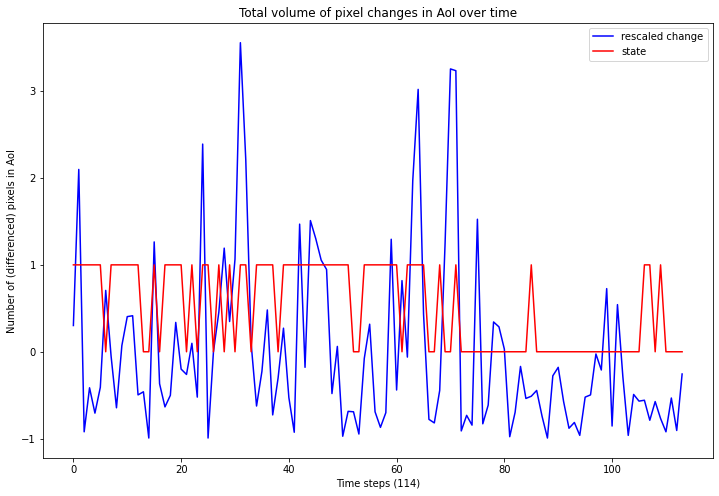

In [ ]:
fig = plt.figure(figsize=(12,8))
# pos_change_ts = pos_change_ts - 1000
# neg_change_ts = neg_change_ts - 1000
# pos_change_ts[pos_change_ts < 2000] = 2000
# neg_change_ts[neg_change_ts < 2000] = 2000 ## Illegal stuff Tim haha

a = abs(pos_change_ts-neg_change_ts)
a_res = (a - np.mean(a) )/np.std(a)

act_new = np.array(valid_activity)[:-1]

plt.plot(a_res, 'blue', label='rescaled change')
plt.plot(act_new, 'red', label='state')
plt.legend()

plt.title('Total volume of pixel changes in AoI over time')
plt.xlabel('Time steps ({})'.format(ts))
plt.ylabel('Number of (differenced) pixels in AoI');

(0.4648102051938729, 1.8897260375117685e-07)


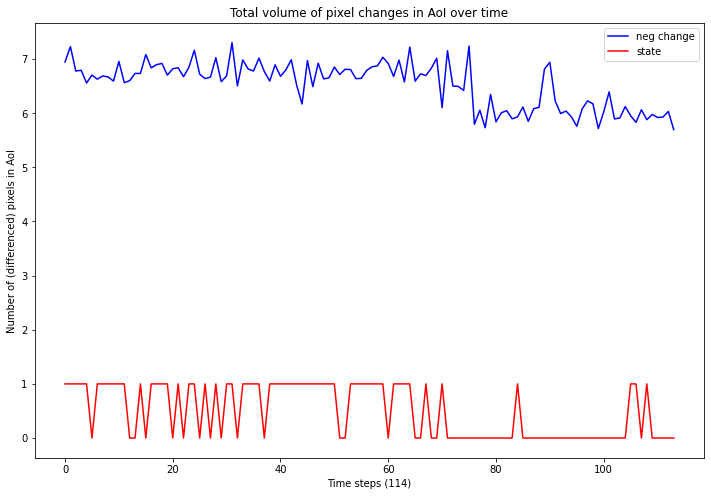

In [ ]:
## (neg_change_ts), act_new have 0.47 corr
## act_new = np.array(valid_activity)[:-1]

a = neg_change_ts
# a_res = (a - np.mean(a) )/np.std(a)
a_res = np.log(a)
# a_res[a_res<0] = 0 ## worse correlation

act_new = np.array(valid_activity)[1:]

print(stats.pearsonr((a_res), act_new))

fig = plt.figure(figsize=(12,8))

plt.plot(a_res, 'blue', label='neg change')
plt.plot(act_new, 'red', label='state')
plt.legend()

plt.title('Total volume of pixel changes in AoI over time')
plt.xlabel('Time steps ({})'.format(ts))
plt.ylabel('Number of (differenced) pixels in AoI');

(0.5106765683971022, 6.441519291320609e-09)


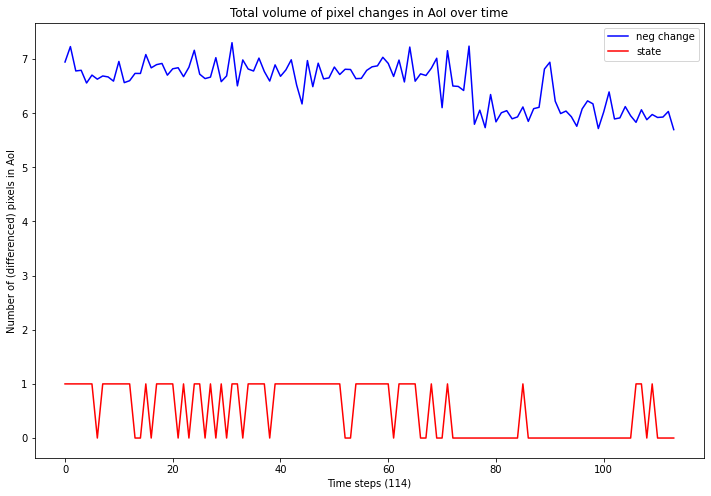

In [ ]:
## (neg_change_ts), act_new have 0.47 corr
## act_new = np.array(valid_activity)[:-1]

a = neg_change_ts
# a_res = (a - np.mean(a) )/np.std(a)
# a_res[a_res<0] = 0
a_res = np.log(a)

act_new = np.array(valid_activity)[:-1]

print(stats.pearsonr((a_res), act_new))

fig = plt.figure(figsize=(12,8))

plt.plot(a_res, 'blue', label='neg change')
plt.plot(act_new, 'red', label='state')
plt.legend()

plt.title('Total volume of pixel changes in AoI over time')
plt.xlabel('Time steps ({})'.format(ts))
plt.ylabel('Number of (differenced) pixels in AoI');

In [ ]:
## (neg_change_ts), act_new have 0.47 corr
## act_new = np.array(valid_activity)[:-1]

a = neg_change_ts
# a_res = (a - np.mean(a) )/np.std(a)
# a_res[a_res<0] = 0
a_res = np.log(a)

act_new = np.array(valid_activity)[:-1]

print(stats.pearsonr((a_res), act_new))

fig = plt.figure(figsize=(12,8))

plt.plot(a_res, 'blue', label='neg change')
plt.plot(act_new, 'red', label='state')
plt.legend()

plt.title('Total volume of pixel changes in AoI over time')
plt.xlabel('Time steps ({})'.format(ts))
plt.ylabel('Number of (differenced) pixels in AoI');

# Findings
---

So far we have 0.47 correlation with the negative pixel values and the standardised negative pixel values. Where 
* the AOI is defined as **top_per , bottom_perc = int(n*0.6) , int(n*0.4)**
* captures[captures == 0] = 0.00001 -- this doesn't change things too much if it is larger or smaller.

The smaller the AOI the larger the correlation with the activity/state array, e.g. AOI defined by **top_per , bottom_perc = int(n*0.55) , int(n*0.45)**, gives 0.481 correlation. 

Taking the log of *np.log(neg_change_ts)* gives correlation of 0.51 for AOI defined by **top_per , bottom_perc = int(n*0.55) , int(n*0.45)**.

---
Drawbacks:
---
*   The AOI definition is not precise. Can fiddle with values until a good correlation pops up.
*   We have arbitrary decided on 2 clusters but what if there are more than 2
*   The percentile filtering - can the outliers be scaled back instead of hardcoded to the upper whiskey of a box plot?
*   The time series created is between two images. What you would probably want is to find out if there is a significant difference from one image to the other. Instead of the pixel change between two images.
*   The sentinel images are around 12 days apart for most smelters I used. Can we add other forms of data to fill in the gap?
*   Some images for a few smelters were even 124 or more days apart in which time we have no idea what has or hasn't changed.
*   Slight misalignment in some images such as Virtue Dragon over the years has occured. It might not be with every smelter but I recon it can be fixed by fixating the image on the water tanks are they are just black rectangles at all times.


----
Further investigations
----

*   Can we draw AOI for car parks, water tanks, stock piles etc and compare the pos/negative changes within those areas only?
*   This method can be merged with CNNs where the k-mean labels for an AOI are fed to the NN and a label is set - or even trying it with the autoencoder as initially suggested.
*   Some bluring could be applied over small regions e.g. Gaussian blur, median filter?




